In [1]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import re, os
import history_cmc as hic
import math
import scipy
from scipy.interpolate import interp1d
from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import gzip
import sys
import astropy as ap
from astropy import units
from scipy.optimize import bisect
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


import gw_ecc_calc as gwcalc
import unit_convert as uc
import merger_rate_calculator as mr
import ns_tidalcapture_hdf5 as tc
import conversions
import dynamics as dyn
import scripts3
import scripts2
import scripts1
import scripts
import LISA_calculations as lisa_calc
import extract_full_hist as ehist
import psr_catalog as pc
import ns, ns_hdf5
import extract_coll_merger as ecm


sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams.update({'font.size': 22})
#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('font',**{'family':'serif','serif':['Times']})
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'Times New Roman'
#plt.rc('font', family='serif')
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
      
twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**-3 ##pc*M_sun**-1*(km/s)2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
Rsun=6.957e+10 ##cm
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun

savepath = '/projects/b1095/syr904/projects/mass_gap_bhs/'

2.1.2


In [2]:
paths = ['/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc1851/N1.3e6rv0.5z0.0013rg20/',
         '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc1851/N1.3e6rv0.5z0.0013rg20_wdtc_wdmass_qcrit4_delay/',
         '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc1851/N1.3e6rv0.5z0.0013rg1_wdtc_wdmass_qcrit4_delay/']
model_type=['1', '4', '7']
snmodel = ['rapid', 'delayed', 'delayed']
wdmassmodel = ['default', 'updated', 'updated']
nstdeflag = ['-', '0.2', '0.2']
wdtcflag = ['-', '\checkmark', '\checkmark']
qcritflag = ['default', 'updated', 'updated']

In [3]:
###return bh snapshot names
def bh_snaps(sourcedir):
    bhsnap_h5 = 'initial.blackhole.snapshots.h5'
    
    with pd.HDFStore(sourcedir+bhsnap_h5) as bhsnap_hdf:
        bhsnap_keys = np.sort(bhsnap_hdf.keys())  
        
    t_conv = dyn.conv('t', sourcedir+'initial.conv.sh')
    
    def read_keys(thekey):
        return re.findall(r'\d+\.\d+|\d+', thekey)
    
    bh_snaptime = []; bh_floattime = []
    for ii in range(len(bhsnap_keys)):
        thetime = read_keys(bhsnap_keys[ii])[0]
        bh_snaptime.append(thetime)
        bh_floattime.append(float(thetime))
    
    ind = np.argsort(bh_floattime)
    bh_floattime_sort = np.array(bh_floattime)[ind]
    bh_snaptime_sort = np.array(bh_snaptime)[ind]
    
    return bh_floattime_sort, bh_snaptime_sort

In [5]:
sourcedir = np.genfromtxt('/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/paths_delay_rapid.dat',
                         dtype=str)
model_type_6752 = np.array(list(sourcedir[:,2][::4])+list(sourcedir[:,2][1::4])+list(sourcedir[:,2][2::4]))#+list(sourcedir[:,2][3::4]))
#sourcedir[:,2]
print(model_type_6752)
paths_6752 = np.array(list(sourcedir[:,0][::4])+list(sourcedir[:,0][1::4])+list(sourcedir[:,0][2::4]))#+list(sourcedir[:,0][3::4]))

snmodel_6752 = np.array(list(sourcedir[:,4][::4])+list(sourcedir[:,4][1::4])+list(sourcedir[:,4][2::4]))
wdmassmodel_6752 = np.array(list(sourcedir[:,5][::4])+list(sourcedir[:,5][1::4])+list(sourcedir[:,5][2::4]))
nstdeflag_6752 = np.array(list(sourcedir[:,6][::4])+list(sourcedir[:,6][1::4])+list(sourcedir[:,6][2::4]))
wdtcflag_6752 = np.array(list(sourcedir[:,7][::4])+list(sourcedir[:,7][1::4])+list(sourcedir[:,7][2::4]))
qcritflag_6752 = np.array(list(sourcedir[:,8][::4])+list(sourcedir[:,8][1::4])+list(sourcedir[:,8][2::4]))

###Appending the model with s=0
model_type_6752 = np.append(model_type_6752, '5')
paths_6752 = np.append(paths_6752, 
          '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_nstde0_wdtc_wdmass_qcrit4_delay/')
snmodel_6752 = np.append(snmodel_6752, 'delayed')
wdmassmodel_6752 = np.append(wdmassmodel_6752, 'updated')
nstdeflag_6752 = np.append(nstdeflag_6752, '0.0')
wdtcflag_6752 = np.append(wdtcflag_6752, '\checkmark')
qcritflag_6752 = np.append(qcritflag_6752, 'updated')

##Appending the model with lower kicks
model_type_6752 = np.append(model_type_6752, '6')
print(model_type_6752)
paths_6752 = np.append(paths_6752, 
        '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_nstde0.2_wdtc_wdmass_qcrit4_delay_lowkick_nobh/')
snmodel_6752 = np.append(snmodel_6752, 'delayed')
wdmassmodel_6752 = np.append(wdmassmodel_6752, 'updated')
nstdeflag_6752 = np.append(nstdeflag_6752, '0.2')
wdtcflag_6752 = np.append(wdtcflag_6752, '\checkmark')
qcritflag_6752 = np.append(qcritflag_6752, 'updated')


print(paths_6752)
snap_h5 = 'initial.snapshots.h5'

delay_sep = 6

['1' '3' '2' '4' '1' '3' '2' '4' '1' '3' '2' '4']
['1' '3' '2' '4' '1' '3' '2' '4' '1' '3' '2' '4' '5' '6']
['/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_rerun/'
 '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_rerun_delay/'
 '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_wdmass/'
 '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_alloff_cotdeoff_wdmass_delay/'
 '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/allfixed/n8-rv0.5-rg8-z0.0002_iccatalog_nstde0.2_wdtc_rerun/'
 '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc6752/al

1166257 1555
11064.5
1173046 1603
11022.5
677113 1257
10995.6


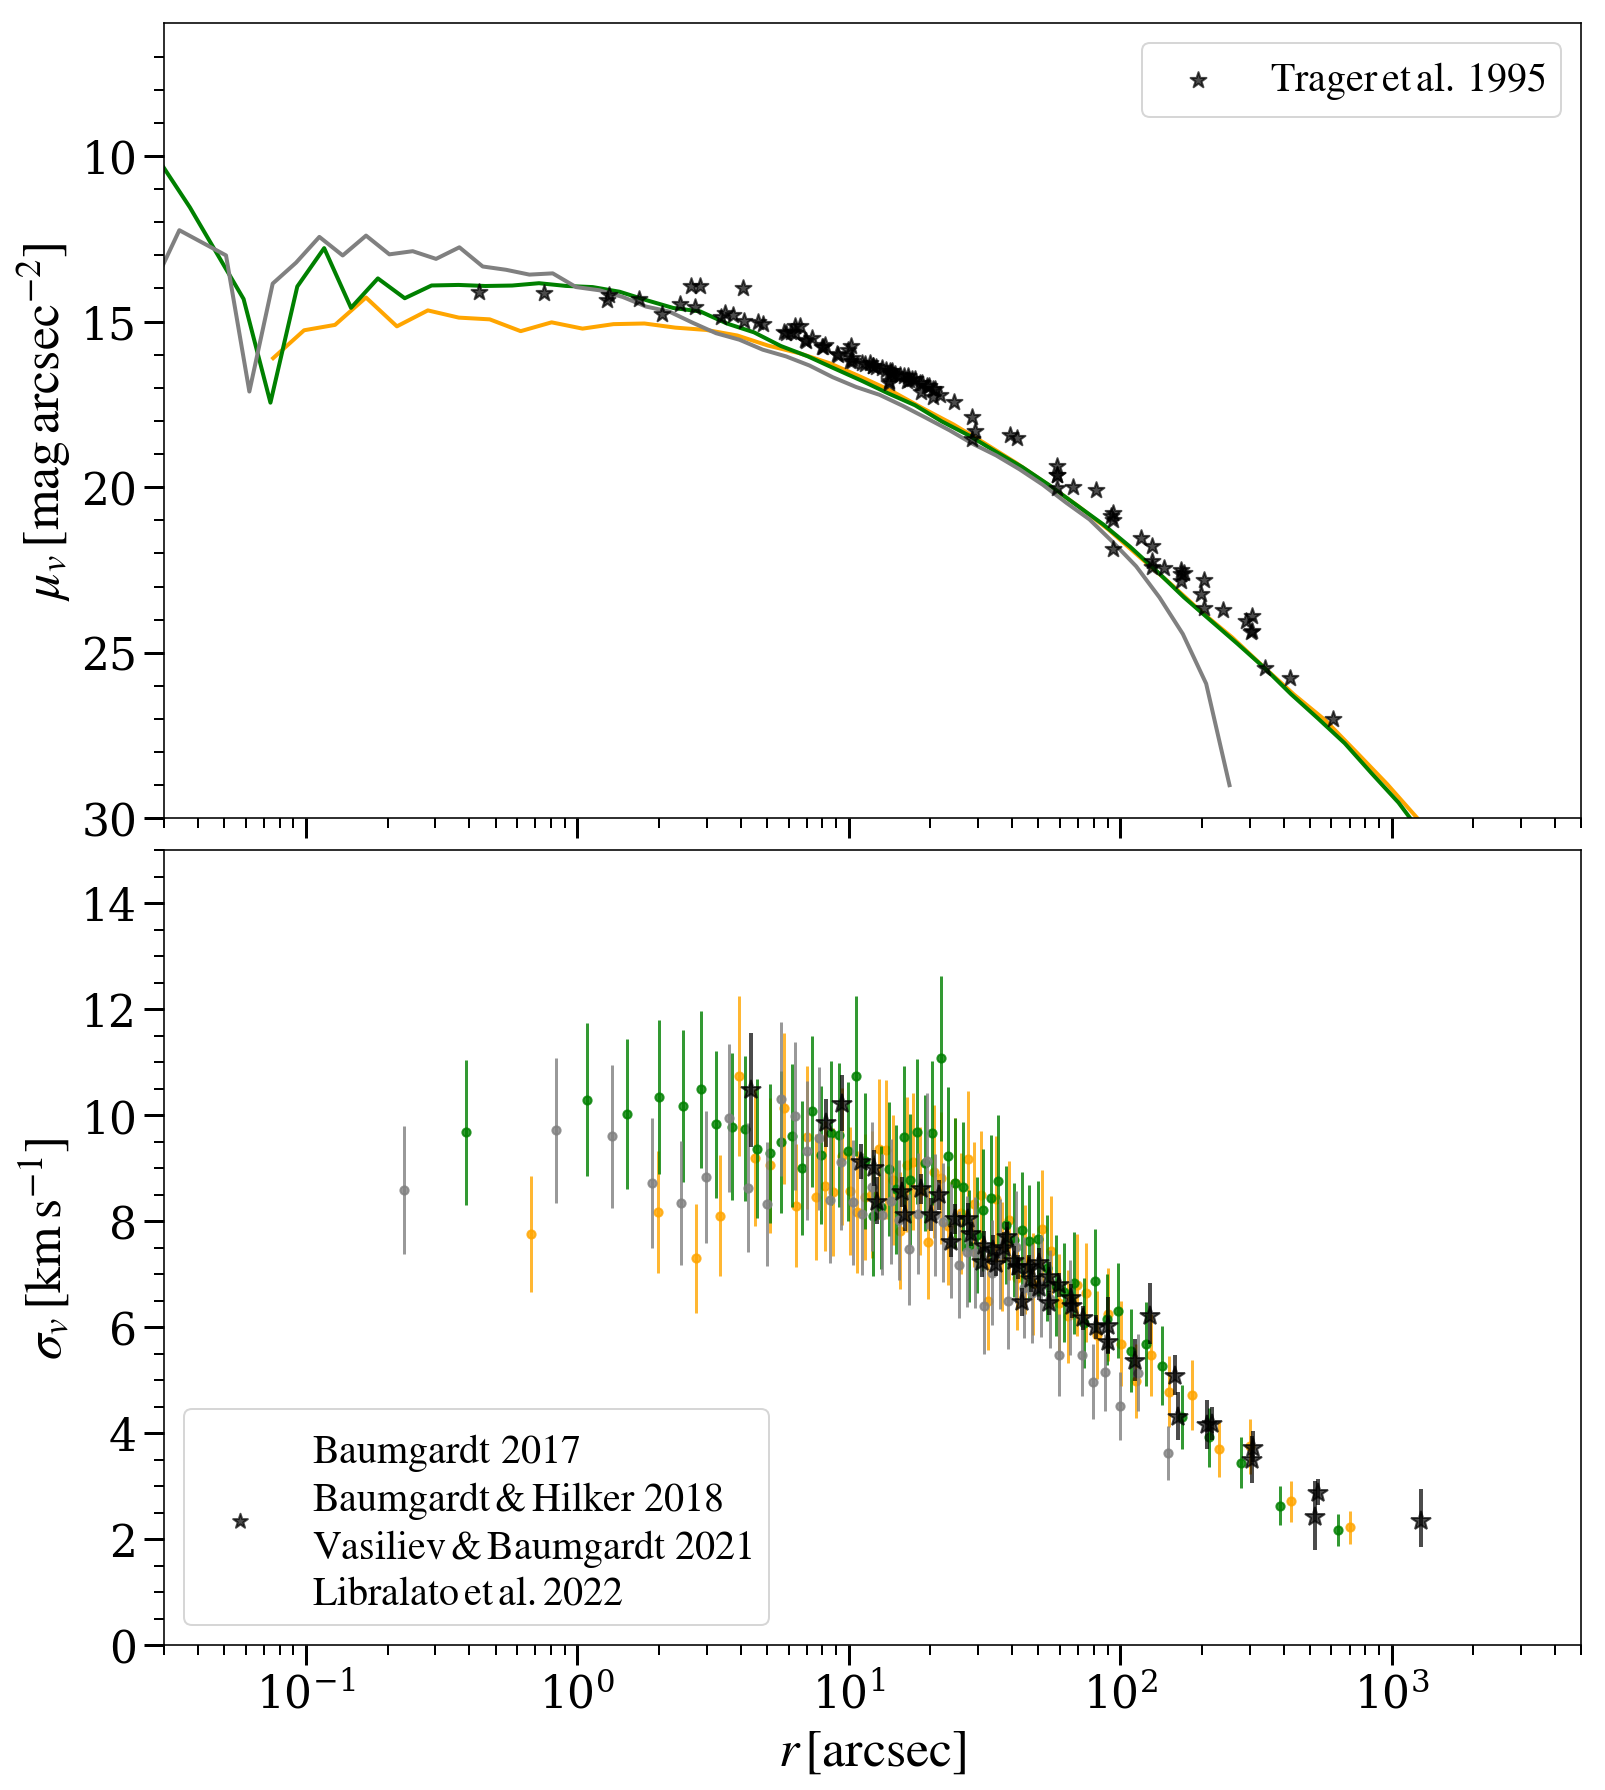

In [15]:
##Surface brightness and velocity dispersion profiles
###Observations###
R_sun_obs=11.95
ngcno='1851'

ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()

fv = open('makeSBP/vel_dispersion_profiles_100423.dat','r')
linesv = fv.readlines()

flag = 0
#### find observed SBP from trager file
arcsec_t = []
SB_t = []
for k in range(len(linest)):
    linet = linest[k]
    linet = linet.split('\n')
    linet = linet[0]
    linet = linet.split('\t')
    cluster_tregar = linet[1]
    if cluster_tregar == 'ngc'+ngcno:
        arcsec_t.append(np.float(linet[2]))
        SB_t.append(np.float(linet[3]))
        flag = 1
arcsec_t = np.array(arcsec_t[:])
SB_t = np.array(SB_t[:])
if flag == 0:
        print('Trager doesnt have the SBP or sigma v profile')
        sys.exit()

flag = 0
#### find observed sigma_v profile
datav = np.genfromtxt('makeSBP/vel_dispersion_profiles_100423.dat')
R_obs = [] # in arcsec
sigma_obs = []
sigma_err_obs_up = []
sigma_err_obs_down = []
for k in range(len(linesv)):
    linev = linesv[k]
    linev = linev.split('\n')
    linev = linev[0]
    linev = linev.split(' ')
    cluster_sigma = linev[0]
    if cluster_sigma == 'NGC'+ngcno:
        R_obs.append(datav[k,1])
        sigma_obs.append(datav[k,2])
        sigma_err_obs_up.append(datav[k,3])
        sigma_err_obs_down.append(datav[k,4])
        flag = 1
R_obs = np.array(R_obs[:])
sigma_obs = np.array(sigma_obs[:])
sigma_err_obs_up = np.array(sigma_err_obs_up[:])
sigma_err_obs_down = np.array(sigma_err_obs_down[:])
############
if flag == 0:
        print('No observed sigmav profile')
        sys.exit()
        

fig, ax=plt.subplots(2, 1, sharex=True,  figsize=(12,13))
#ax[0].set_title(r'$\rm{NGC}\ $'+ngcno, fontsize=20)
ax[0].scatter(10**arcsec_t[:], SB_t[:], facecolor='k', marker = '*', 
              alpha=0.7, s=70, label=r'$\rm{Trager\,et\,al.\,1995}$', zorder=3)
ax[1].errorbar(R_obs,sigma_obs,yerr=[sigma_err_obs_down,sigma_err_obs_up], fmt='*', 
               markersize = 10, alpha=0.7, c='k', lw=2.0,zorder=3)
ax[1].scatter([10000,10000], [-5,-5], c='k', marker = '*', alpha=0.7, s=60,
              label=r'$\rm{Baumgardt\,\,2017}$' '\n'
              r'$\rm{Baumgardt\,&\,Hilker\,\,2018}$' '\n'
              r'$\rm{Vasiliev\,&\,Baumgardt\,\,2021}$' '\n'
              r'$\rm{Libralato\,et\,al.2022}$')
             
cs = ['orange', 'green', 'gray']#cm.winter(np.linspace(0.1, 1, 2))
ms = ['o', 'o', 'o']
ts = [11000., 11000., 10900.]
###Models###
for xx in range(len(paths)):
    snap2D = np.sort(glob(paths[xx]+'initial.snap*.2Dproj.dat.gz'))
    snap2D_L12 = np.sort(glob(paths[xx]+'initial.snap*.2D_SBPLcut12_NCUT-1.dat'))
    snap_vel700 = np.sort(glob(paths[xx]+'initial.snap*.vel_dispersion_vr_pm_100_0.8.dat'))

    for ii in range(0, len(snap2D_L12)):
        with open(snap2D_L12[ii], 'r') as f2D:
            first_line=f2D.readline()

        t_gyr = float(first_line.strip().split('=')[-1])
        if t_gyr>=ts[xx]:
            Ltot = []
            with gzip.open(snap2D[ii], 'r') as f2Dproj:
                next(f2Dproj); next(f2Dproj)
                for line in f2Dproj:
                    data = line.split()
                    Ltot.append(float(data[1]))
            Ltot = np.array(Ltot)
            print(len(Ltot), len(Ltot)-len(Ltot[Ltot<=12]))
            
            print(t_gyr)
            data5 = np.genfromtxt(snap2D_L12[ii])
            arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
            SB = conversions.SB_converter(data5[:,3])
            SBerr = data5[:,6]/data5[:,5]*SB
            
            arcsec_cut = []
            SB_cut = []
            SBerr_cut = []
            for k in range(len(SB)):
                if arcsec[k] < 10 and SB[k] > 20:
                    Nothing = 0
                else:
                    arcsec_cut.append(arcsec[k])
                    SB_cut.append(SB[k])
                    #SBerr_cut.append(SBerr[k])
        
            datavel = np.genfromtxt(snap_vel700[ii])
            R_model = conversions.pc_to_arcsec(datavel[:,0],R_sun_obs)
            sigma_model = datavel[:,1]
            sigma_err_model = datavel[:,2]
        
            ax[0].plot(arcsec_cut, SB_cut, lw=2, color=cs[xx])
            ax[0].plot([10000,10000],[-5,-5], lw=2, color=cs[xx])
            ax[1].scatter(R_model[::3], sigma_model[::3],s=17,zorder=2, color=cs[xx], marker=ms[xx],alpha=0.8)
            ax[1].errorbar(R_model[::3],sigma_model[::3],yerr=2*sigma_err_model[::3], fmt=ms[xx],
                           markersize=0.01,zorder=2, color=cs[xx], alpha=0.8)

            break

ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].set_ylim(30,6)
ax[0].set_xscale('log')
ax[0].set_xlim(0.03,5000)
ax[0].set_ylabel(r'$\mu_v\,[\rm{mag\,arcsec^{-2}}]$',fontsize=26)
#ax[0].set_xlabel(r'$r\,[\rm{arcsec}]$',fontsize=26)
ax[0].tick_params('both', length=10, width=1.5, which='major')
ax[0].tick_params('both', length=5, width=1, which='minor')
ax[0].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 20})

ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].set_xscale('log')
ax[1].set_xlim(0.03,5000)
ax[1].set_ylim(0, 15)
ax[1].set_xlabel(r'$r\,[\rm{arcsec}]$',fontsize=26)
ax[1].set_ylabel(r'$\sigma_v\,[\rm{km\,s^{-1}}]$',fontsize=26)
ax[1].tick_params('both', length=10, width=1.5, which='major')
ax[1].tick_params('both', length=5, width=1, which='minor')
ax[1].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})

fig.tight_layout()
plt.subplots_adjust(hspace=0.04)
#plt.savefig(savepath+'sbp_vdp_1851_11Gyr.pdf', dpi=300)

11984.7
11931.7
12153.3
11906.2
11966.6
11903.2
12085.6
12006.0
12078.8
11918.7
11981.8
12082.5
12137.7
12035.4
11064.5
11022.5


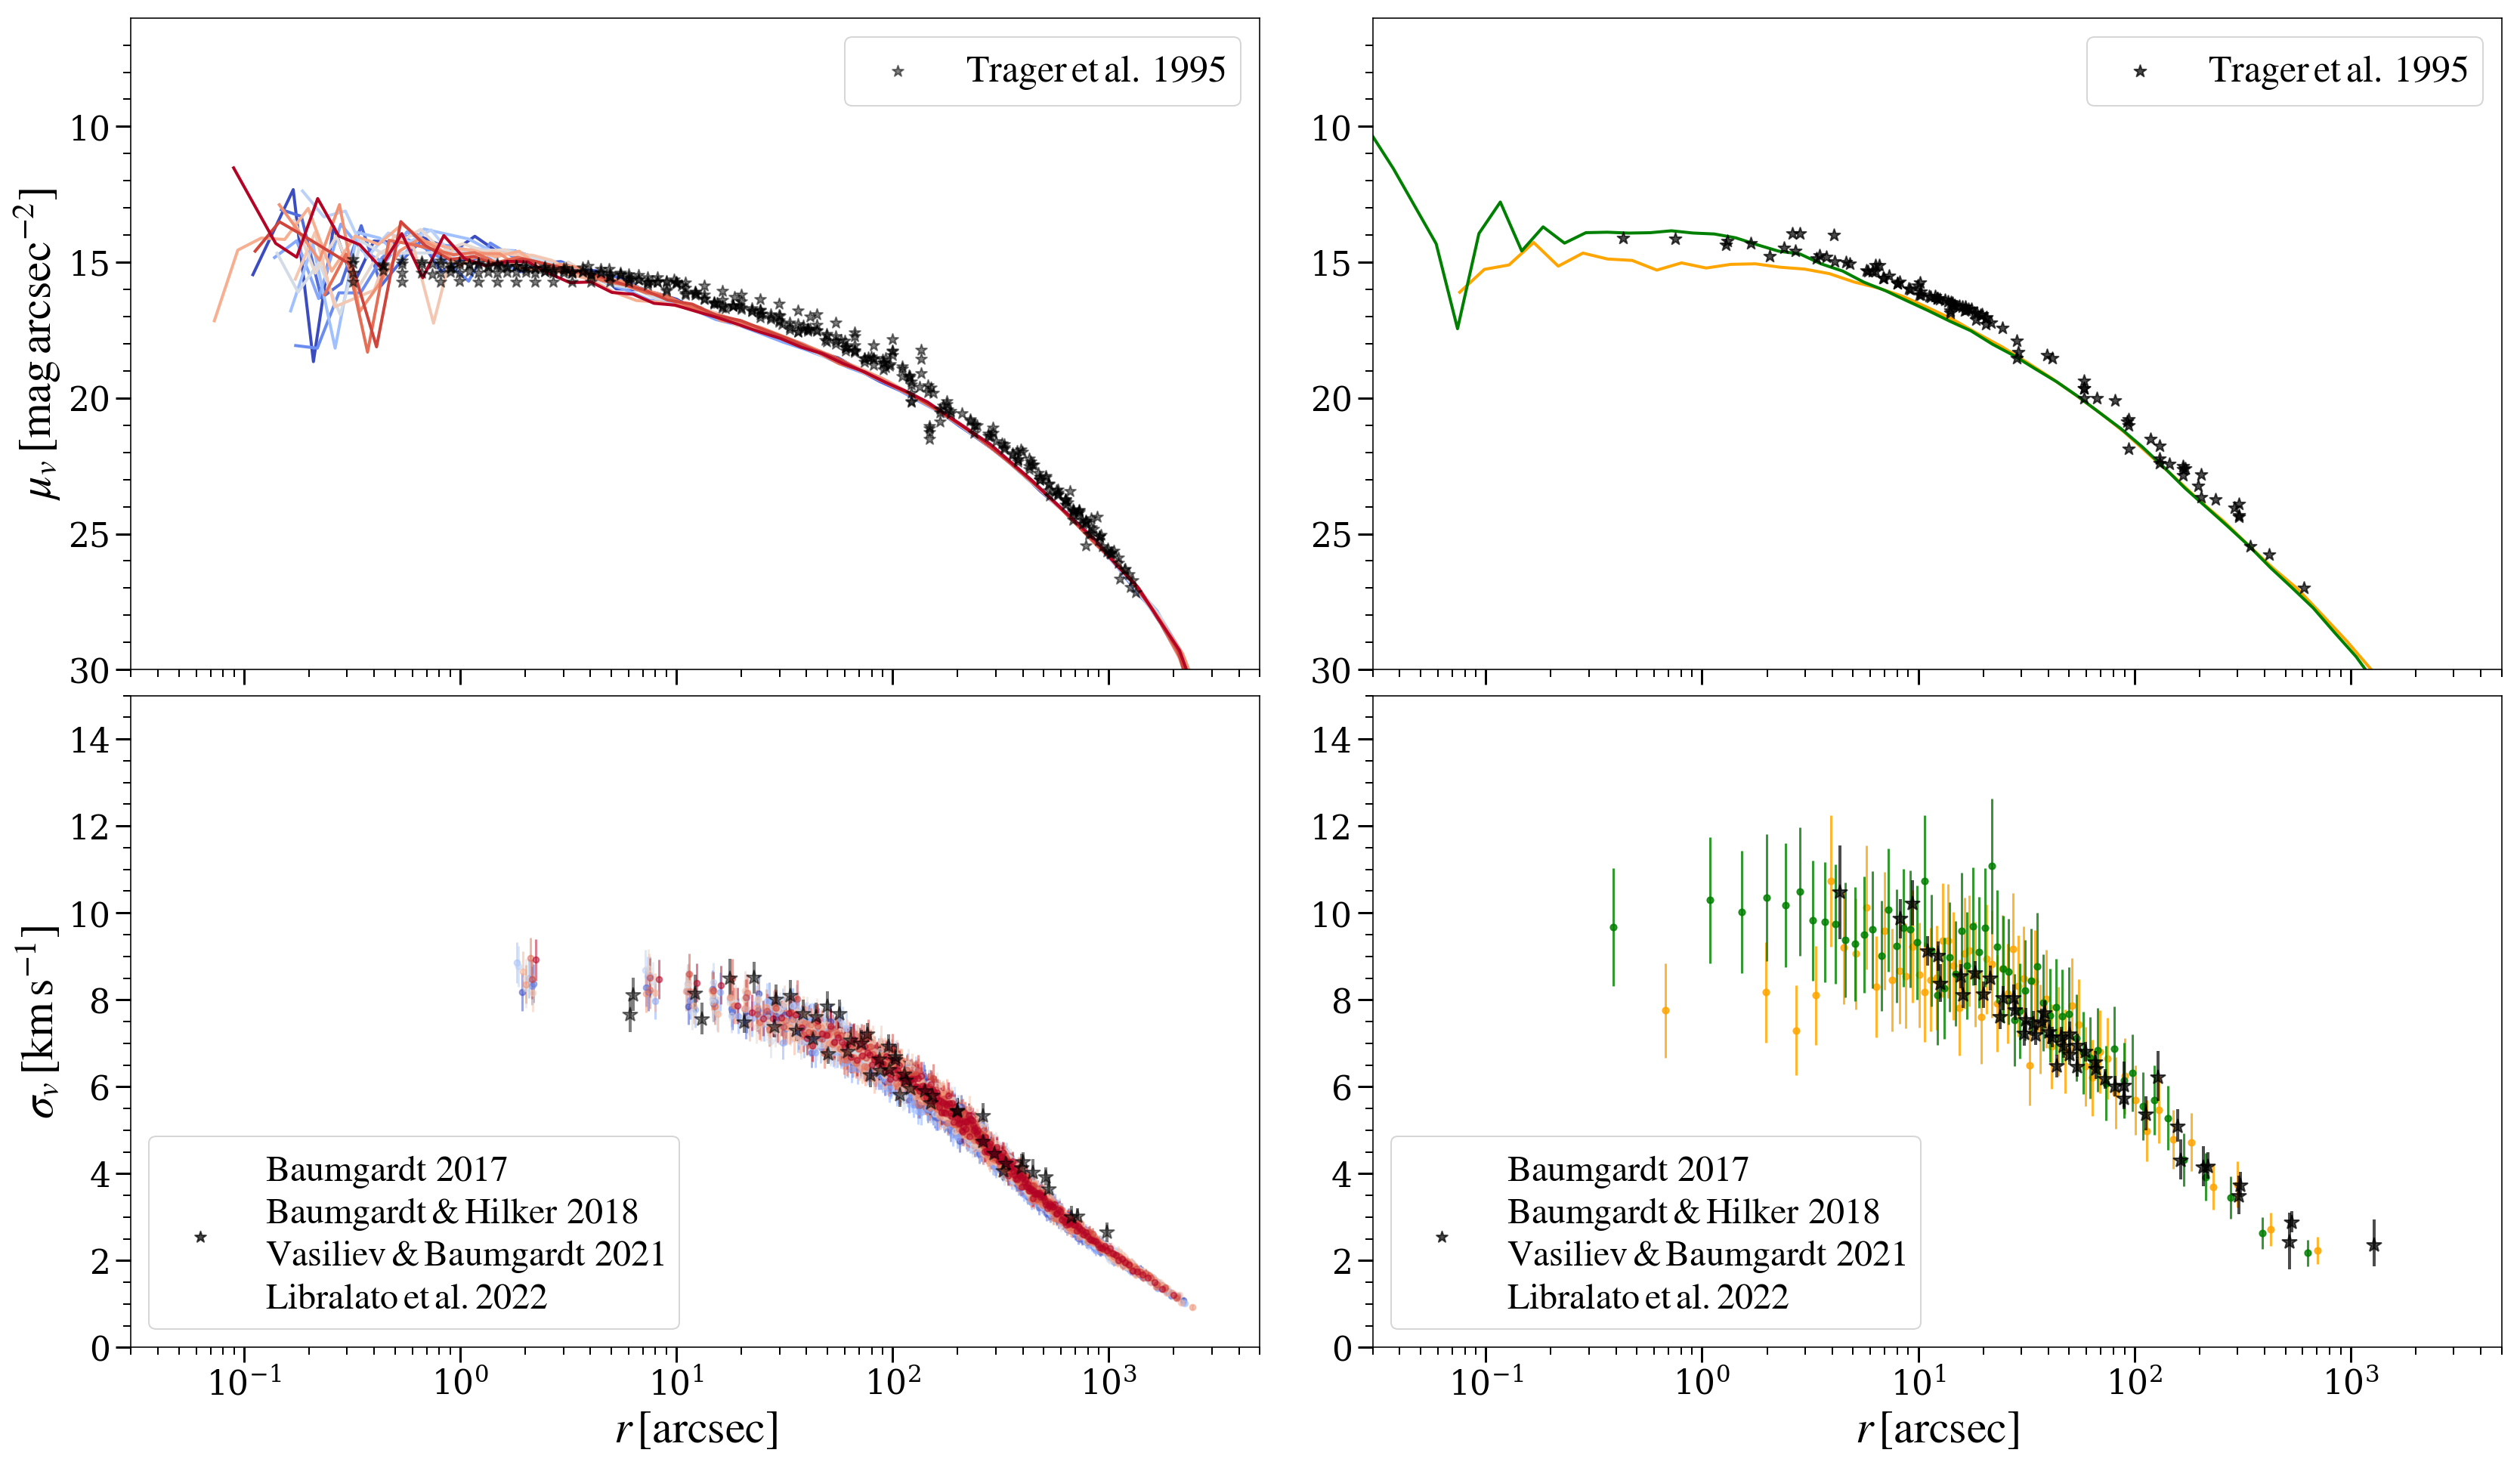

In [8]:
##Surface brightness and velocity dispersion profiles
###Observations###
R_sun_obs=[4.125, 11.95]
ngcno=['6752', '1851']

ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()

fv = open('makeSBP/vel_dispersion_profiles_100423.dat','r')
linesv = fv.readlines()

fig, ax=plt.subplots(nrows=2, ncols=2, sharex=True,  figsize=(24,14))
for ss in range(len(R_sun_obs)):
    flag = 0
    #### find observed SBP from trager file
    arcsec_t = []
    SB_t = []
    for k in range(len(linest)):
        linet = linest[k]
        linet = linet.split('\n')
        linet = linet[0]
        linet = linet.split('\t')
        cluster_tregar = linet[1]
        if cluster_tregar == 'ngc'+ngcno[ss]:
            arcsec_t.append(np.float(linet[2]))
            SB_t.append(np.float(linet[3]))
            flag = 1
    arcsec_t = np.array(arcsec_t[:])
    SB_t = np.array(SB_t[:])
    if flag == 0:
            print('Trager doesnt have the SBP or sigma v profile')
            sys.exit()
    
    flag = 0
    #### find observed sigma_v profile
    datav = np.genfromtxt('makeSBP/vel_dispersion_profiles_100423.dat')
    R_obs = [] # in arcsec
    sigma_obs = []
    sigma_err_obs_up = []
    sigma_err_obs_down = []
    for k in range(len(linesv)):
        linev = linesv[k]
        linev = linev.split('\n')
        linev = linev[0]
        linev = linev.split(' ')
        cluster_sigma = linev[0]
        if cluster_sigma == 'NGC'+ngcno[ss]:
            R_obs.append(datav[k,1])
            sigma_obs.append(datav[k,2])
            sigma_err_obs_up.append(datav[k,3])
            sigma_err_obs_down.append(datav[k,4])
            flag = 1
    R_obs = np.array(R_obs[:])
    sigma_obs = np.array(sigma_obs[:])
    sigma_err_obs_up = np.array(sigma_err_obs_up[:])
    sigma_err_obs_down = np.array(sigma_err_obs_down[:])
    ############
    if flag == 0:
            print('No observed sigmav profile')
            sys.exit()
            
    if ss==0:
        ax[0][ss].scatter(10**arcsec_t[:], SB_t[:], facecolor='k', marker = '*', 
                      alpha=0.5, s=60, label=r'$\rm{Trager\,et\,al.\,1995}$', zorder=3)
        ax[1][ss].errorbar(R_obs,sigma_obs,yerr=[sigma_err_obs_down,sigma_err_obs_up], fmt='*', 
                       markersize = 10, alpha=0.5, c='k', lw=2.0)
        ax[1][ss].scatter([10000,10000], [-5,-5], c='k', marker = '*', alpha=0.7, s=60,
                      label=r'$\rm{Baumgardt\,\,2017}$' '\n'
                      r'$\rm{Baumgardt\,&\,Hilker\,\,2018}$' '\n'
                      r'$\rm{Vasiliev\,&\,Baumgardt\,\,2021}$' '\n'
                      r'$\rm{Libralato\,et\,al.2022}$')
                     
        cs = cm.coolwarm(np.linspace(0., 1, 14))
        ###Models###
        for xx in range(len(paths_6752)):
            snap2D = np.sort(glob(paths_6752[xx]+'initial.snap*.2Dproj.dat.gz'))
            snap2D_L12 = np.sort(glob(paths_6752[xx]+'initial.snap*.2D_SBPLcut12_NCUT-1.dat'))
            snap_vel700 = np.sort(glob(paths_6752[xx]+'initial.snap*.vel_dispersion_vr_pm_700_0.dat'))
        
            for ii in range(0, len(snap2D_L12)):
                with open(snap2D_L12[ii], 'r') as f2D:
                    first_line=f2D.readline()
        
                t_gyr = float(first_line.strip().split('=')[-1])
                if t_gyr>=11900.:
                    print(t_gyr)
                    data5 = np.genfromtxt(snap2D_L12[ii])
                    arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs[ss])
                    SB = conversions.SB_converter(data5[:,3])
                    SBerr = data5[:,6]/data5[:,5]*SB
                    
                    arcsec_cut = []
                    SB_cut = []
                    SBerr_cut = []
                    for k in range(len(SB)):
                        if arcsec[k] < 10 and SB[k] > 20:
                            Nothing = 0
                        else:
                            arcsec_cut.append(arcsec[k])
                            SB_cut.append(SB[k])
                            #SBerr_cut.append(SBerr[k])
                
                    datavel = np.genfromtxt(snap_vel700[ii])
                    R_model = conversions.pc_to_arcsec(datavel[:,0],R_sun_obs[ss])
                    sigma_model = datavel[:,1]
                    sigma_err_model = datavel[:,2]
                
                    ax[0][ss].plot(arcsec_cut, SB_cut, lw=2, color=cs[xx])
                    ax[0][ss].plot([10000,10000],[-5,-5], lw=2, color=cs[xx])
                    ax[1][ss].scatter(R_model[::3], sigma_model[::3],s=15,zorder=2,alpha=0.5, color=cs[xx])
                    ax[1][ss].errorbar(R_model[::3],sigma_model[::3],yerr=2*sigma_err_model[::3], fmt='o',
                                   markersize=0.01,zorder=1,alpha=0.5, color=cs[xx])
        
                    break
            
    if ss==1:
        ax[0][ss].scatter(10**arcsec_t[:], SB_t[:], facecolor='k', marker = '*', 
                      alpha=0.7, s=70, label=r'$\rm{Trager\,et\,al.\,1995}$', zorder=3)
        ax[1][ss].errorbar(R_obs,sigma_obs,yerr=[sigma_err_obs_down,sigma_err_obs_up], fmt='*', 
                       markersize = 10, alpha=0.7, c='k', lw=2.0,zorder=3)
        ax[1][ss].scatter([10000,10000], [-5,-5], c='k', marker = '*', alpha=0.7, s=60,
                      label=r'$\rm{Baumgardt\,\,2017}$' '\n'
                      r'$\rm{Baumgardt\,&\,Hilker\,\,2018}$' '\n'
                      r'$\rm{Vasiliev\,&\,Baumgardt\,\,2021}$' '\n'
                      r'$\rm{Libralato\,et\,al.2022}$')
                     
        cs = ['orange', 'green']#cm.winter(np.linspace(0.1, 1, 2))
        ms = ['o', 'o']
        ts = [11000., 11000.]
        ###Models###
        for xx in range(len(paths)-1):
            snap2D = np.sort(glob(paths[xx]+'initial.snap*.2Dproj.dat.gz'))
            snap2D_L12 = np.sort(glob(paths[xx]+'initial.snap*.2D_SBPLcut12_NCUT-1.dat'))
            snap_vel700 = np.sort(glob(paths[xx]+'initial.snap*.vel_dispersion_vr_pm_100_0.8.dat'))
        
            for ii in range(0, len(snap2D_L12)):
                with open(snap2D_L12[ii], 'r') as f2D:
                    first_line=f2D.readline()
        
                t_gyr = float(first_line.strip().split('=')[-1])
                if t_gyr>=ts[xx]:
                    print(t_gyr)
                    data5 = np.genfromtxt(snap2D_L12[ii])
                    arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs[ss])
                    SB = conversions.SB_converter(data5[:,3])
                    SBerr = data5[:,6]/data5[:,5]*SB
                    
                    arcsec_cut = []
                    SB_cut = []
                    SBerr_cut = []
                    for k in range(len(SB)):
                        if arcsec[k] < 10 and SB[k] > 20:
                            Nothing = 0
                        else:
                            arcsec_cut.append(arcsec[k])
                            SB_cut.append(SB[k])
                            #SBerr_cut.append(SBerr[k])
                
                    datavel = np.genfromtxt(snap_vel700[ii])
                    R_model = conversions.pc_to_arcsec(datavel[:,0],R_sun_obs[ss])
                    sigma_model = datavel[:,1]
                    sigma_err_model = datavel[:,2]
                
                    ax[0][ss].plot(arcsec_cut, SB_cut, lw=2, color=cs[xx])
                    ax[0][ss].plot([10000,10000],[-5,-5], lw=2, color=cs[xx])
                    ax[1][ss].scatter(R_model[::3], sigma_model[::3],s=17,zorder=2, color=cs[xx], marker=ms[xx],alpha=0.8)
                    ax[1][ss].errorbar(R_model[::3],sigma_model[::3],yerr=2*sigma_err_model[::3], fmt=ms[xx],
                                   markersize=0.01,zorder=2, color=cs[xx], alpha=0.8)
        
                    break
    
    ax[0][ss].yaxis.set_minor_locator(AutoMinorLocator())
    ax[0][ss].set_ylim(30,6)
    ax[0][ss].set_xscale('log')
    ax[0][ss].set_xlim(0.03,5000)
    ax[0][ss].tick_params('both', length=10, width=1.5, which='major')
    ax[0][ss].tick_params('both', length=5, width=1, which='minor')
    ax[0][ss].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 25})
    
    ax[1][ss].yaxis.set_minor_locator(AutoMinorLocator())
    ax[1][ss].set_xscale('log')
    ax[1][ss].set_xlim(0.03,5000)
    ax[1][ss].set_ylim(0, 15)
    ax[1][ss].set_xlabel(r'$r\,[\rm{arcsec}]$',fontsize=30)
    ax[1][ss].tick_params('both', length=10, width=1.5, which='major')
    ax[1][ss].tick_params('both', length=5, width=1, which='minor')
    ax[1][ss].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 24})

ax[0][0].set_ylabel(r'$\mu_v\,[\rm{mag\,arcsec^{-2}}]$',fontsize=30)
ax[1][0].set_ylabel(r'$\sigma_v\,[\rm{km\,s^{-1}}]$',fontsize=30)
fig.tight_layout()
plt.subplots_adjust(hspace=0.04,wspace=0.1)
#plt.savefig(savepath+'sbp_vdp_1851_11Gyr_6752_12Gyr.pdf', dpi=300)



bh 10.954502938677999
ns 10954.502938677999
bh 11.048969456318
ns 10963.787139379
813 28 841
0 [ 8.89993156  6.3344749  11.23062672  9.25573237  7.45805666 14.49677238
  8.31504307 11.05733656  7.3876717   8.870771   11.86307976  7.55729748
  9.89540979  8.60531861  8.87991738  6.68179442  6.0996453   7.95006941
  7.73104791 14.22026269  5.79601323  6.50333062  8.02173574  9.24953967
  9.72664377  6.48684737 15.16738475 10.40368922]
0 0 0
1 []
0 0 0
2 []
923 32 955
3 [ 5.18488761  6.28261109 11.39378105  5.27381247 15.54357868 17.80281357
  8.4032841   6.48531775 20.38879898  8.62043241  7.39679991  9.8148442 ]


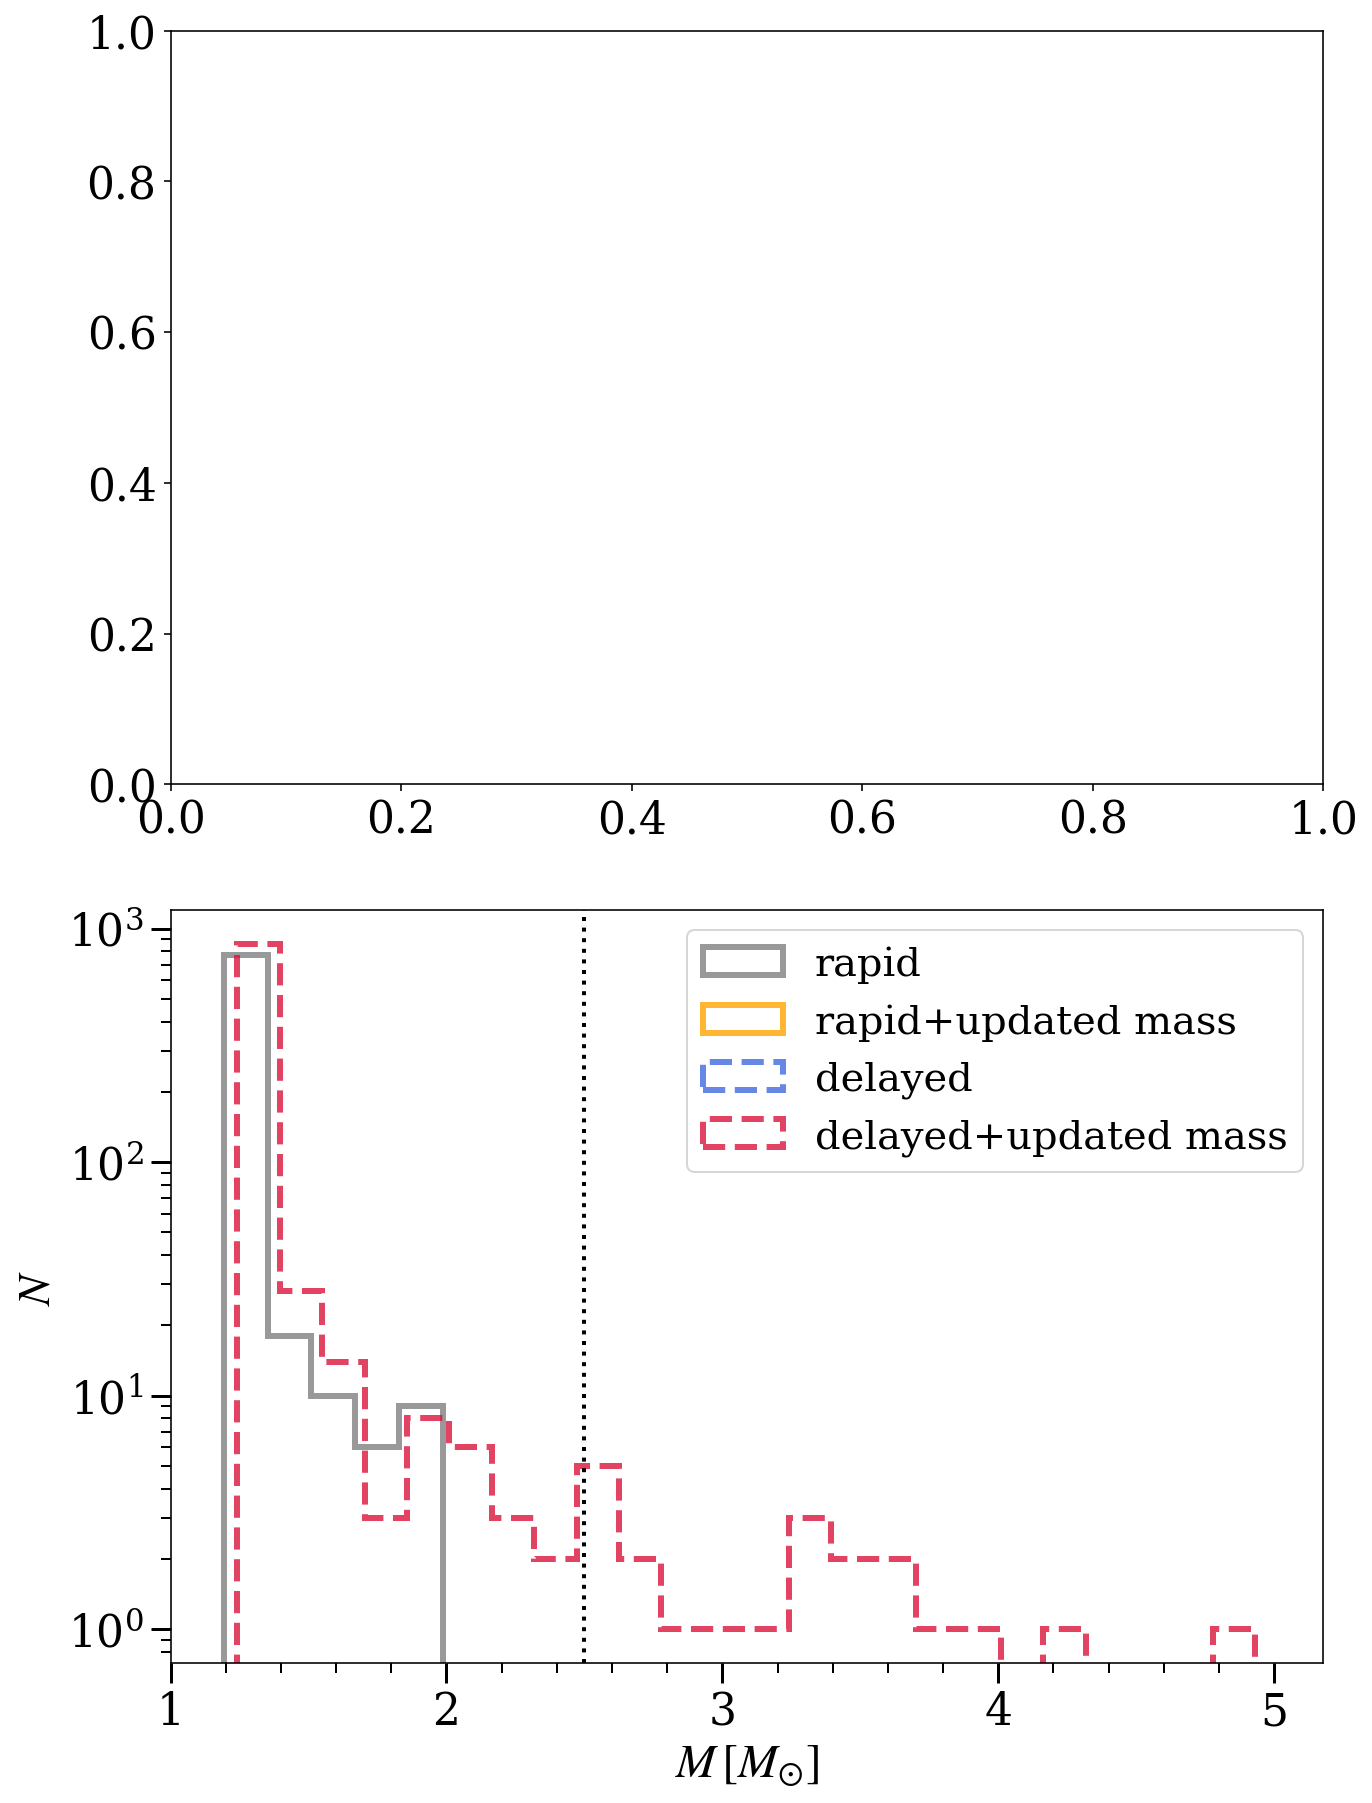

In [29]:
##Black hole and neutron star mass at late times (13 Gyr here)
M_bh = [[],[],[],[]]; M_ns = [[],[],[],[]]
for xx in range(len(paths)):
    snapt_float, snaptime_sort = bh_snaps(paths[xx])
    
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    
    for yy in range(len(snaptime_sort)):
        if float(snaptime_sort[yy])*t_conv>=10950.:
            bh_h5 = cmct.Snapshot(fname=paths[xx]+'initial.blackhole.snapshots.h5', 
                                    snapshot_name='/t='+snaptime_sort[yy], 
                                    conv=paths[xx]+'initial.conv.sh', 
                                    dist=11.95, # distance to cluster in kpc
                                    z=0.0013)
            print('bh', bh_h5.age)
            binflag = np.array(bh_h5.data['binflag'])
            m = np.array(bh_h5.data['m_MSUN'])[binflag!=1]
            k0 = np.array(bh_h5.data['bin_startype0'])[binflag==1]; k1 = np.array(bh_h5.data['bin_startype1'])[binflag==1]
            m0 = np.array(bh_h5.data['m0_MSUN'])[binflag==1]; m1 = np.array(bh_h5.data['m1_MSUN'])[binflag==1]
            
            M_bh[int(model_type[xx])-1] = M_bh[int(model_type[xx])-1]+list(m)
            for zz in range(len(k0)):
                if k0[zz]==14:
                    M_bh[int(model_type[xx])-1].append(m0[zz])
                if k1[zz]==14:
                    M_bh[int(model_type[xx])-1].append(m1[zz])
                        
            break

    t_old = 14000.
    with open(paths[xx]+'initial.morepulsars.dat', 'r') as fpsr:
        next(fpsr)
        for line in fpsr:
            datapsr = line.split()
            if float(datapsr[1])*t_conv > t_old:
                break
            if float(datapsr[1])*t_conv>=10950.:
                
                if int(datapsr[2])!=1:
                    M_ns[int(model_type[xx])-1].append(float(datapsr[5]))
                else:
                    if int(datapsr[11])==13:
                        M_ns[int(model_type[xx])-1].append(float(datapsr[5]))
                    if int(datapsr[12])==13:
                        M_ns[int(model_type[xx])-1].append(float(datapsr[6]))
                
                t_old = float(datapsr[1])*t_conv
    print('ns', t_old)

#print(M_bh)
#print(M_ns)               

fig, axs = plt.subplots(nrows=2, figsize=(10,13))
lss = ['-', '-', '--', '--']
cs = ['gray', 'orange', 'royalblue', 'crimson']
labels = ['rapid', 'rapid+updated mass', 'delayed', 'delayed+updated mass']
bin_no = [5,22,15,24]

#axs.axvline(x=5, ls = 'dotted', color='green', lw=2)
axs[1].axvline(x=2.5, ls = 'dotted', color='k', lw=2)
for ii in range(4):
    print(len(M_ns[ii]), len(M_bh[ii]), len(M_ns[ii]+M_bh[ii]))
    print(ii, np.array(M_ns[ii]+M_bh[ii])[np.array(M_ns[ii]+M_bh[ii])>5])
    axs[1].hist(np.array(M_ns[ii]+M_bh[ii])[np.array(M_ns[ii]+M_bh[ii])<=5.],
             bins=bin_no[ii],
            histtype='step', ls = lss[ii], lw=3, color = cs[ii], alpha=0.8,
            label = labels[ii])
    

axs[1].set_xlim(xmin=1.)
axs[1].set_yscale('log')
axs[1].xaxis.set_minor_locator(AutoMinorLocator())
axs[1].tick_params('both', length=10, width=1.5, which='major')
axs[1].tick_params('both', length=5, width=1, which='minor')
axs[1].set_xlabel(r'$M\,[M_{\odot}]$', fontsize=24)
axs[1].set_ylabel(r'$N$', fontsize=23)
axs[1].legend(loc='upper right', fontsize=20)


#axs[0].hist(bh_kicks_all, bins=25,
#        cumulative=True, density=True,
#        lw=3, histtype='step', color = 'k', alpha=0.6, label=r'$M_{\rm BH} \leq 5\,M_{\odot}$')
#axs[0].hist(ns_kicks_all, bins=25, 
#        cumulative=True, density=True,
#        lw=3, histtype='step', color = 'blue', ls='--', alpha=0.6, label=r'$M_{\rm NS} \geq 2\,M_{\odot}$')
##axs[0].set_xlim(xmax = np.max(ns_kicks_all))
#axs[0].set_xlabel(r'$v_{\rm{kick}}\,[\rm{km\,s^{-1}}]$', fontsize=24)
#axs[0].set_ylabel('Cumulative Fraction')
#axs[0].legend(loc='upper left')
#axs[0].xaxis.set_minor_locator(AutoMinorLocator())
#axs[0].yaxis.set_minor_locator(AutoMinorLocator())
#axs[0].tick_params('both', length=10, width=1.5, which='major')
#axs[0].tick_params('both', length=5, width=1, which='minor')
    
fig.tight_layout()

#plt.savefig(savepath+'mass_gap_kicks_Mbhns_12Gyr.pdf', dpi=300)


In [5]:
##Number of NS TDEs in different models
##For collisions with more than one star,
##e.g., one NS colliding with 2 MS,
##there will be two TDE printouts in the error.out file
##may want to subtract the number here; write in paper

##For both NSs and BHs because we care about mass gap objects here

N_tde = []

Mnew_all = [[],[]]; Macc_all = [[],[]]
Bnew_all = [[],[]]; Bold_all = [[],[]]; Pnew_all = [[],[]]; Pold_all = [[],[]]
idtde_all = []; idtde_latercoll_all = []
idtde_msp_all = []; idtde_msp_norepeater = []
ttde = []

N_ns2bh = []
ttot_myr = []
for xx in range(len(paths)):
    m_ns = []; B_ns = []; Ospin_ns = []
    m_new = []; B_new = []; Ospin_new = []; Macc = []
    m_star_all = []; k_star_all = []
    #nbh = 0
    
    error_out = paths[xx]+'error.out'
    with open(error_out, 'r') as ferr:
        for line in ferr:
            data=line.split()
            if data[0]=='Before':
                m_star = float(data[3].split('=')[1])
                r_star = float(data[4].split('=')[1])
                k_star = float(data[5].split('=')[1])
                m_ns.append(float(data[6].split('=')[1]))
                B_ns.append(float(data[7].split('=')[1]))
                Ospin_ns.append(float(data[8].split('=')[1]))
                
                m_star_all.append(m_star); k_star_all.append(k_star)
            if data[0]=='After':
                m_new.append(float(data[3].split('=')[1]))
                B_new.append(float(data[4].split('=')[1]))
                Ospin_new.append(float(data[5].split('=')[1]))
                Macc.append(float(data[6].split('=')[1]))
    
    Psec_old = twopi*yearsc/np.array(Ospin_ns)
    Psec_new = twopi*yearsc/np.array(Ospin_new)
    
    print(len(Psec_old), len(Psec_old[Psec_old<=0.03]), len(Psec_new[Psec_new<=0.03]))  ##write in paper
    N_ns2bh.append(len(np.array(m_new)[np.array(m_new)>2.5]))
    
    #print(xx, len(Psec_new[np.array(m_new)<=2.5]))
    N_tde.append(len(Psec_new))
    
    idtde = np.full(len(m_star_all),-100)
    ttde.append(np.full(len(m_star_all),-100.0))
    
    #if xx <= ab_cut:
    #    Mnew_all[0] = Mnew_all[0]+m_new
    #    Macc_all[0] = Macc_all[0]+Macc
    #    Bold_all[0] = Bold_all[0]+B_ns
    #    Bnew_all[0] = Bnew_all[0]+B_new
    #    Pold_all[0] = Pold_all[0]+list(Psec_old)
    #    Pnew_all[0] = Pnew_all[0]+list(Psec_new)
    #else:
    #    Mnew_all[1] = Mnew_all[1]+m_new
    #    Macc_all[1] = Macc_all[1]+Macc
    #    Bold_all[1] = Bold_all[1]+B_ns
    #    Bnew_all[1] = Bnew_all[1]+B_new
    #    Pold_all[1] = Pold_all[1]+list(Psec_old)
    #    Pnew_all[1] = Pnew_all[1]+list(Psec_new)
        
        
    ##Check the collision file
    nsms_coll = np.genfromtxt(paths[xx]+'ns_nsms_coll.dat')
    t_myr = nsms_coll[:,1]; k3 = nsms_coll[:,12]; k4 = nsms_coll[:,13]
    ttot_myr = ttot_myr+list(t_myr)
    #print('num coll', len(t_myr))
    #print('repeat', len(k3[k3!=-100]), len(k4[k4!=-100]))
    
    ns_collproduct = np.genfromtxt(paths[xx]+'ns_collproduct_all.dat')
    mcollall = [ns_collproduct[:,5], ns_collproduct[:,6], ns_collproduct[:,7], ns_collproduct[:,8]]
    kcollall = [ns_collproduct[:,10], ns_collproduct[:,11], ns_collproduct[:,12], ns_collproduct[:,13]]
    idm_nscol = ns_collproduct[:,2].astype(np.int)
    idall_nscol = [ns_collproduct[:,14].astype(np.int),ns_collproduct[:,15].astype(np.int),
                   ns_collproduct[:,16].astype(np.int),ns_collproduct[:,17].astype(np.int)]
    t_nscoll =  ns_collproduct[:,1]
    if ns_collproduct[:,9][0]!=13:
        print('ns coll wtf')
    
    bh_collproduct = np.genfromtxt(paths[xx]+'bh_collproduct_all.dat')
    bh_mcollall = [bh_collproduct[:,5], bh_collproduct[:,6], bh_collproduct[:,7], bh_collproduct[:,8]]
    bh_kcollall = [bh_collproduct[:,10], bh_collproduct[:,11], bh_collproduct[:,12], bh_collproduct[:,13]]
    idm_bhcol = bh_collproduct[:,2].astype(np.int)
    idall_bhcol = [bh_collproduct[:,14].astype(np.int),bh_collproduct[:,15].astype(np.int),
                   bh_collproduct[:,16].astype(np.int),bh_collproduct[:,17].astype(np.int)]
    t_bhcoll =  bh_collproduct[:,1]
    if bh_collproduct[:,9][0]!=14:
        print('bh coll wtf')
    
    ns_merproduct = np.genfromtxt(paths[xx]+'ns_mergerproduct_all.dat')
    idm_nsmer = ns_merproduct[:,2].astype(np.int)
    t_nsmer = ns_merproduct[:,1]
    idall_nsmer = [ns_merproduct[:,10].astype(np.int),ns_merproduct[:,11].astype(np.int)]
    if ns_merproduct[:,7][0]!=13:
        print('ns mer wtf')
    
    bh_merproduct = np.genfromtxt(paths[xx]+'bh_mergerproduct_all.dat')
    idm_bhmer = bh_merproduct[:,2].astype(np.int)
    t_bhmer = bh_merproduct[:,1]
    idall_bhmer = [bh_merproduct[:,10].astype(np.int),bh_merproduct[:,11].astype(np.int)]
    if bh_merproduct[:,7][0]!=14:
        print('bh mer wtf')
    
    ###Finding the IDs of TDE NSs###
    ##First combine the arrays##
    bhns_mcollall = np.concatenate((mcollall,bh_mcollall), axis=1)
    #print(bhns_mcollall, len(bhns_mcollall))
    bhns_kcollall = np.concatenate((kcollall,bh_kcollall), axis=1)
    idm_bhnscol = np.concatenate((idm_nscol, idm_bhcol))
    idm_bhnsmer = np.concatenate((idm_nsmer, idm_bhmer))
    t_bhnscoll = np.concatenate((t_nscoll,t_bhcoll))
    idall_bhnscol = np.concatenate((idall_nscol, idall_bhcol), axis=1)
    idall_bhnsmer = np.concatenate((idall_nsmer, idall_bhmer), axis=1)
    
    
    ##Then loop through the TDEs##
    for kk in range(len(m_star_all)):
        for zz in range(len(bhns_mcollall)):
            if len(bhns_mcollall[zz][bhns_mcollall[zz]==round(m_star_all[kk], 6)])>0:
                if len(bhns_mcollall[zz][bhns_mcollall[zz]==round(m_star_all[kk], 6)])>1:
                    print('Oh no')
                    print(bhns_mcollall[zz][bhns_mcollall[zz]==round(m_star_all[kk], 6)], m_star_all[kk])
                    if bhns_mcollall[zz-1][bhns_mcollall[zz]==round(m_star_all[kk], 6)][0]==m_ns[kk]:
                        print('yes')
                        if bhns_kcollall[zz][bhns_mcollall[zz]==round(m_star_all[kk], 6)][0]==k_star_all[kk]:
                            idtde[kk]=idm_bhnscol[bhns_mcollall[zz]==round(m_star_all[kk], 6)][0]
                            ttde[xx][kk] = t_bhnscoll[bhns_mcollall[zz]==round(m_star_all[kk], 6)][0]
                            continue
                            
                if bhns_kcollall[zz][bhns_mcollall[zz]==round(m_star_all[kk], 6)][0]==k_star_all[kk]:
                    #print(idm_bhnscol[bhns_mcollall[zz]==round(m_star_all[kk], 6)],
                    #     t_bhnscoll[bhns_mcollall[zz]==round(m_star_all[kk], 6)])
                    idtde[kk]=idm_bhnscol[bhns_mcollall[zz]==round(m_star_all[kk], 6)][0]
                    ttde[xx][kk] = t_bhnscoll[bhns_mcollall[zz]==round(m_star_all[kk], 6)][0]

                    
        if idtde[kk]==-100:
            if len(bhns_kcollall[0][(bhns_mcollall[0]+bhns_mcollall[1])==m_star_all[kk]])>0:
                #print(m_star_all[kk])
                #print(mcollall[0][(mcollall[0]+mcollall[1])==m_star_all[kk]][0], mcollall[1][(mcollall[0]+mcollall[1])==m_star_all[kk]][0])
                if bhns_kcollall[0][(bhns_mcollall[0]+bhns_mcollall[1])==m_star_all[kk]][0]<=1. or bhns_kcollall[1][(bhns_mcollall[0]+bhns_mcollall[1])==m_star_all[kk]][0]<=1.:
                    idtde[kk]=idm_bhnscol[(bhns_mcollall[0]+bhns_mcollall[1])==m_star_all[kk]]
                    ttde[xx][kk] = t_bhnscoll[(bhns_mcollall[0]+bhns_mcollall[1])==m_star_all[kk]]
                    
        if idtde[kk]==-100:
            if len(bhns_kcollall[0][np.round((bhns_mcollall[0]+bhns_mcollall[1]), 5)==m_star_all[kk]])>0:
                #print(mcollall[0][np.round((mcollall[0]+mcollall[1]), 5)==m_star_all[kk]])
                #print(mcollall[1][np.round((mcollall[0]+mcollall[1]), 5)==m_star_all[kk]])
                #print(m_star_all[kk])
                if bhns_kcollall[0][np.round((bhns_mcollall[0]+bhns_mcollall[1]), 5)==m_star_all[kk]][0]<=1. or bhns_kcollall[1][np.round((bhns_mcollall[0]+bhns_mcollall[1]),5)==m_star_all[kk]][0]<=1.:
                    #print(m_star_all[kk])
                    idtde[kk]=idm_bhnscol[np.round((bhns_mcollall[0]+bhns_mcollall[1]), 5)==m_star_all[kk]]
                    ttde[xx][kk] = t_bhnscoll[np.round((bhns_mcollall[0]+bhns_mcollall[1]), 5)==m_star_all[kk]]
                    #print(idtde[kk])
                    
        if idtde[kk]==-100:
            if len(bhns_kcollall[0][np.round((bhns_mcollall[0]+bhns_mcollall[1]), 5)==round(m_star_all[kk],5)])>0:
                if bhns_kcollall[0][np.round((bhns_mcollall[0]+bhns_mcollall[1]), 5)==round(m_star_all[kk],5)][0]<=1. or bhns_kcollall[1][np.round((bhns_mcollall[0]+bhns_mcollall[1]),5)==round(m_star_all[kk],5)][0]<=1.:
                    idtde[kk]=idm_bhnscol[np.round((bhns_mcollall[0]+bhns_mcollall[1]), 5)==round(m_star_all[kk],5)]
                    ttde[xx][kk] = t_bhnscoll[np.round((bhns_mcollall[0]+bhns_mcollall[1]), 5)==round(m_star_all[kk],5)]
        
        #if idtde[kk]==-100:
        #    for zz in range(len(bh_mcollall)):
        #        if len(bh_mcollall[zz][bh_mcollall[zz]==round(m_star_all[kk], 6)])>0:
        #            if len(bh_mcollall[zz][bh_mcollall[zz]==round(m_star_all[kk], 6)])>1:
        #                print('Oh no')
        #                #print(bh_mcollall[zz][bh_mcollall[zz]==round(m_star_all[kk], 6)])
        #            if bh_kcollall[zz][bh_mcollall[zz]==round(m_star_all[kk], 6)][0]==k_star_all[kk]:
        #                nbh+=1
                        
            
    print(paths[xx])        
    print('num of TDE?', len(idtde[idtde>=0]))
    print(np.array(m_star_all)[idtde==-100])
    #print('nbh', nbh)
    print('ttde', len(ttde[xx]), len(t_myr))

    idtde_old = idtde
    idtde = np.array(list(Counter(idtde).keys()))
    #print(idtde)
    idtde_all.append(idtde[idtde>0])
    
    ##Counting subsequent mergers/collisions
    idtde_latercoll = []
    idtde_latercoll_msp = []
    for hh in range(len(idtde)):
        if idtde[hh]==0 or idtde[hh]==-100:
            continue
        for gg in range(len(idall_bhnscol)):
            if idtde[hh] in idall_bhnscol[gg] and idm_bhnscol[idall_bhnscol[gg]==idtde[hh]][0] not in idtde:
                #print('repeated collisions', idall_nscol[gg][idall_nscol[gg]==idtde[hh]], idtde[hh])
                idtde_latercoll.append(idm_bhnscol[idall_bhnscol[gg]==idtde[hh]][0])
                if Psec_new[hh]<=0.03:
                    idtde_latercoll_msp.append(idm_bhnscol[idall_bhnscol[gg]==idtde[hh]][0])
                
        for gg in range(len(idall_bhnsmer)):
            if idtde[hh] in idall_bhnsmer[gg]:
                for ff in range(len(idm_bhnsmer[idall_bhnsmer[gg]==idtde[hh]])):
                    if idm_bhnsmer[idall_bhnsmer[gg]==idtde[hh]][ff]!=idtde[hh]:
                        idtde_latercoll.append(idm_bhnsmer[idall_bhnsmer[gg]==idtde[hh]][ff])       
                        if Psec_new[hh]<=0.03:
                            idtde_latercoll_msp.append(idm_bhnsmer[idall_bhnsmer[gg]==idtde[hh]][ff])
    
    for aa in range(4):
        for hh in range(len(idtde_latercoll)):
            if idtde_latercoll[hh]==0:
                continue
            for gg in range(len(idall_bhnscol)):
                if idtde_latercoll[hh] in idall_bhnscol[gg] and idm_bhnscol[idall_bhnscol[gg]==idtde_latercoll[hh]][0] not in idtde:
                    idtde_latercoll.append(idm_bhnscol[idall_bhnscol[gg]==idtde_latercoll[hh]][0])
                    #print(gg, idall_nscol[gg][idall_nscol[gg]==idtde_latercoll[hh]], idtde_latercoll[hh])
                    k_temp = [bhns_kcollall[0][idall_bhnscol[gg]==idtde_latercoll[hh]],
                             bhns_kcollall[1][idall_bhnscol[gg]==idtde_latercoll[hh]],
                             bhns_kcollall[2][idall_bhnscol[gg]==idtde_latercoll[hh]],
                             bhns_kcollall[3][idall_bhnscol[gg]==idtde_latercoll[hh]]]
                    if idtde_latercoll[hh] in idtde_latercoll_msp:# or (0. in k_temp or 1. in k_temp):
                         idtde_latercoll_msp.append(idm_bhnscol[idall_bhnscol[gg]==idtde_latercoll[hh]][0])
                    
            for gg in range(len(idall_bhnsmer)):
                if idtde_latercoll[hh] in idall_bhnsmer[gg]:
                    for ff in range(len(idm_bhnsmer[idall_bhnsmer[gg]==idtde_latercoll[hh]])):
                        if idm_bhnsmer[idall_bhnsmer[gg]==idtde_latercoll[hh]][ff]!=idtde_latercoll[hh]:
                            idtde_latercoll.append(idm_bhnsmer[idall_bhnsmer[gg]==idtde_latercoll[hh]][ff]) 
                            if idtde_latercoll[hh] in idtde_latercoll_msp:
                                idtde_latercoll_msp.append(idm_bhnsmer[idall_bhnsmer[gg]==idtde_latercoll[hh]][ff]) 
    
    #print(idtde_latercoll, idtde_latercoll_msp)
    idtde_latercoll = np.array(list(Counter(idtde_latercoll).keys()))
    idtde_latercoll_msp = list(Counter(idtde_latercoll_msp).keys())
    print('later_ns', len(idtde_latercoll))
    print('later_msp', len(idtde_latercoll_msp))
    
    idtde_latercoll_all.append(idtde_latercoll)
    
    idtde_msp_all.append(np.array(list(Counter(list(idtde_old[(idtde_old>0) & (Psec_new<=0.03)])+ 
                                         idtde_latercoll_msp).keys())))
    print('num of tde msp?', len(idtde_msp_all[xx]))
    idtde_msp_norepeater.append(np.array(list(Counter(idtde_old[(idtde_old>0) & (Psec_new<=0.03)]).keys())))
    

##Rates of NS-MS TDEs
n_tde_9gyr  = []
for kk in range(len(ttde)):
    if len(ttde[kk])>0:
        n_tde_9gyr.append(len(ttde[kk][ttde[kk]>=9000.]))
print('mean number of TDEs at > 9 Gyr', np.mean(n_tde_9gyr))
print('TDE rates at > 9 Gyr', np.mean(n_tde_9gyr)/((13.8-9.)*10**9)*2.31*10**9)

print(N_ns2bh)

0 0 0
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc1851/N1.3e6rv0.5z0.0013rg20/
num of TDE? 0
[]
ttde 0 25
later_ns 0
later_msp 0
num of tde msp? 0
241 49 238
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc1851/N1.3e6rv0.5z0.0013rg20_wdtc_wdmass_qcrit4_delay/
num of TDE? 240
[1.70839]
ttde 241 209
later_ns 41
later_msp 41
num of tde msp? 268
mean number of TDEs at > 9 Gyr 221.0
TDE rates at > 9 Gyr 106.35624999999999
[0, 1]


In [6]:
###Number of NS formed in WDWD collision and mergers
###PSR and non-PSR

N_ns_wdwdcoll = [[],[]]
N_wdwdcoll_tot = []
N_ns_wdwdmer = [[],[]]
N_wdwdmer_tot = []
id_wdwdcol_all = []; id_wdwdmer_all = []
id_wdwdcol_norepeater = []; id_wdwdmer_norepeater = []
type_wdwdcol_all = []; type_wdwdmer_all = []
type_wdwdcol_norepeater = []; type_wdwdmer_norepeater = []
interact_first = []

for xx in range(len(paths)):
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')

    psrfile = paths[xx]+'initial.morepulsars.dat'
    
    wdwd_coll_file = np.genfromtxt(paths[xx]+'ns_wdwd_coll.dat')
    id_coll = wdwd_coll_file[:,2].astype(np.int)
    k0_coll = wdwd_coll_file[:,10].astype(np.int); k1_coll = wdwd_coll_file[:,11].astype(np.int)
    print('N_ns_wdwd_coll:', xx, len(id_coll))
    print('coll zeros', len(id_coll[id_coll==0]))
    N_wdwdcoll_tot.append(len(id_coll))
    k0_coll = k0_coll[id_coll!=0]; k1_coll = k1_coll[id_coll!=0]
    id_coll = id_coll[id_coll!=0]
    
    wdwd_mer_file = np.genfromtxt(paths[xx]+'ns_wdwd_merger.dat')
    print(len(wdwd_mer_file))
    if len(wdwd_mer_file)>0:
        if len(wdwd_mer_file.shape)>1:
            id_mer = wdwd_mer_file[:,2].astype(np.int)
            k0_mer = wdwd_mer_file[:,8].astype(np.int); k1_mer = wdwd_mer_file[:,9].astype(np.int)
            print('N_ns_wdwd_mer:', xx, len(id_mer))
            print('mer zeros', len(id_mer[id_mer==0]))
            N_wdwdmer_tot.append(len(id_mer))
            k0_mer = k0_mer[id_mer!=0]; k1_mer = k1_mer[id_mer!=0]
            id_mer = id_mer[id_mer!=0]
            #print(id_mer)
        else:
            id_mer = np.array([wdwd_mer_file[2].astype(np.int)])
            k0_mer = np.array([wdwd_mer_file[8].astype(np.int)]); k1_mer = np.array([wdwd_mer_file[9].astype(np.int)])
            print(id_mer)
            print('N_ns_wdwd_mer:', xx, len(id_mer))
            print('mer zeros', len(id_mer[id_mer==0]))
            N_wdwdmer_tot.append(len(id_mer))
            k0_mer = k0_mer[id_mer!=0]; k1_mer = k1_mer[id_mer!=0]
            id_mer = id_mer[id_mer!=0]
    else:
        id_mer = np.array([])
        k0_mer = np.array([]); k1_mer = np.array([])
        print('N_ns_wdwd_mer:', xx, len(id_mer))
        print('mer zeros', len(id_mer))
        N_wdwdmer_tot.append(len(id_mer))
        
    
    ns_collproduct = np.genfromtxt(paths[xx]+'ns_collproduct_all.dat')
    idm_nscol = ns_collproduct[:,2].astype(np.int)
    idall_nscol = [ns_collproduct[:,14].astype(np.int),ns_collproduct[:,15].astype(np.int),
                   ns_collproduct[:,16].astype(np.int),ns_collproduct[:,17].astype(np.int)]
    if ns_collproduct[:,9][0]!=13:
        print(xx, 'ns wtf')
    
    ns_merproduct = np.genfromtxt(paths[xx]+'ns_mergerproduct_all.dat')
    idm_nsmer = ns_merproduct[:,2].astype(np.int)
    t_nsmer = ns_merproduct[:,1]
    idall_nsmer = [ns_merproduct[:,10].astype(np.int),ns_merproduct[:,11].astype(np.int)]
    
    bh_collproduct = np.genfromtxt(paths[xx]+'bh_collproduct_all.dat')
    idm_bhcol = bh_collproduct[:,2].astype(np.int)
    idall_bhcol = [bh_collproduct[:,14].astype(np.int),bh_collproduct[:,15].astype(np.int),
                   bh_collproduct[:,16].astype(np.int),bh_collproduct[:,17].astype(np.int)]
    
    bh_merproduct = np.genfromtxt(paths[xx]+'bh_mergerproduct_all.dat')
    idm_bhmer = bh_merproduct[:,2].astype(np.int)
    t_bhmer = bh_merproduct[:,1]
    idall_bhmer = [bh_merproduct[:,10].astype(np.int),bh_merproduct[:,11].astype(np.int)]
    if bh_merproduct[:,7][0]!=14:
        print(xx, 'bh wtf')
    
    ##First combine the arrays##
    idm_bhnscol = np.concatenate((idm_nscol, idm_bhcol))
    idm_bhnsmer = np.concatenate((idm_nsmer, idm_bhmer))
    idall_bhnscol = np.concatenate((idall_nscol, idall_bhcol), axis=1)
    idall_bhnsmer = np.concatenate((idall_nsmer, idall_bhmer), axis=1)
    
    n_wdwd_tde = 0
    ##Counting subsequent mergers/collisions
    ##Exclude the ones that go through TDEs and TDE subsequent mergers/collisions
    idcoll_latercoll = []
    idmer_latercoll = []
    typecoll_latercoll = []
    typemer_latercoll = []
    ##For the first one only consider the NS files since almost all WD-WD remnants are NSs
    for hh in range(len(id_coll)):
        if id_coll[hh]==0:
            continue           
        for kk in range(len(idall_bhnscol)):
            if id_coll[hh] in idall_bhnscol[kk]:
                if idm_bhnscol[idall_bhnscol[kk]==id_coll[hh]][0] in idtde_all[xx]:
                    n_wdwd_tde+=1
                    
                if idm_bhnscol[idall_bhnscol[kk]==id_coll[hh]][0] not in idtde_all[xx]: 
                    idcoll_latercoll.append(idm_bhnscol[idall_bhnscol[kk]==id_coll[hh]][0])
                    typecoll_latercoll.append(np.str(k0_coll[hh])+np.str(k1_coll[hh]))
        for kk in range(len(idall_bhnsmer)):
            if id_coll[hh] in idall_bhnsmer[kk]:
                for gg in range(len(idm_bhnsmer[idall_bhnsmer[kk]==id_coll[hh]])):
                    if idm_bhnsmer[idall_bhnsmer[kk]==id_coll[hh]][gg]!=id_coll[hh]:
                        idcoll_latercoll.append(idm_bhnsmer[idall_bhnsmer[kk]==id_coll[hh]][gg])
                        typecoll_latercoll.append(np.str(k0_coll[hh])+np.str(k1_coll[hh]))

                        
    for ll in range(len(id_mer)):
        if id_mer[ll]==0:
            continue
        for mm in range(len(idall_bhnscol)):
            if id_mer[ll] in idall_bhnscol[mm]:
                if idm_bhnscol[idall_bhnscol[mm]==id_mer[ll]][0] in idtde_all[xx]:
                    n_wdwd_tde+=1
                    
                if idm_bhnscol[idall_bhnscol[mm]==id_mer[ll]][0] not in idtde_all[xx]:
                    idmer_latercoll.append(idm_bhnscol[idall_bhnscol[mm]==id_mer[ll]][0])
                    typemer_latercoll.append(np.str(k0_mer[ll])+np.str(k1_mer[ll]))

        for mm in range(len(idall_bhnsmer)):
            if id_mer[ll] in idall_bhnsmer[mm]:
                for nn in range(len(idm_bhnsmer[idall_bhnsmer[mm]==id_mer[ll]])):
                    if idm_bhnsmer[idall_bhnsmer[mm]==id_mer[ll]][nn]!=id_mer[ll]:
                        idmer_latercoll.append(idm_bhnsmer[idall_bhnsmer[mm]==id_mer[ll]][nn])
                        typemer_latercoll.append(np.str(k0_mer[ll])+np.str(k1_mer[ll]))
                        
    print('n_wdwd_tde', n_wdwd_tde)

    ##For the second and third one look at both BH and NS files
    for aa in range(4):
        for hh in range(len(idcoll_latercoll)):
            if idcoll_latercoll[hh]==0:
                continue 
            for kk in range(len(idall_bhnscol)):
                if idcoll_latercoll[hh] in idall_bhnscol[kk]:
                    if idm_bhnscol[idall_bhnscol[kk]==idcoll_latercoll[hh]][0] not in idtde_all[xx]:
                        idcoll_latercoll.append(idm_bhnscol[idall_bhnscol[kk]==idcoll_latercoll[hh]][0])
                        typecoll_latercoll.append(typecoll_latercoll[hh])
                    
            for kk in range(len(idall_bhnsmer)):
                if idcoll_latercoll[hh] in idall_bhnsmer[kk]:
                    for gg in range(len(idm_bhnsmer[idall_bhnsmer[kk]==idcoll_latercoll[hh]])):
                        if idm_bhnsmer[idall_bhnsmer[kk]==idcoll_latercoll[hh]][gg]!=idcoll_latercoll[hh]:
                            idcoll_latercoll.append(idm_bhnsmer[idall_bhnsmer[kk]==idcoll_latercoll[hh]][gg])
                            typecoll_latercoll.append(typecoll_latercoll[hh])
                            
        for ll in range(len(idmer_latercoll)):
            if idmer_latercoll[ll]==0:
                continue
            for mm in range(len(idall_bhnscol)):
                if idmer_latercoll[ll] in idall_bhnscol[mm]:
                    if idm_bhnscol[idall_bhnscol[mm]==idmer_latercoll[ll]][0] not in idtde_all[xx]:
                        idmer_latercoll.append(idm_bhnscol[idall_bhnscol[mm]==idmer_latercoll[ll]][0])
                        typemer_latercoll.append(typemer_latercoll[ll])
                
            for mm in range(len(idall_bhnsmer)):
                if idmer_latercoll[ll] in idall_bhnsmer[mm]:
                    for nn in range(len(idm_bhnsmer[idall_bhnsmer[mm]==idmer_latercoll[ll]])):
                        if idm_bhnsmer[idall_bhnsmer[mm]==idmer_latercoll[ll]][nn]!=idmer_latercoll[ll]:
                            idmer_latercoll.append(idm_bhnsmer[idall_bhnsmer[mm]==idmer_latercoll[ll]][nn])
                            typemer_latercoll.append(typemer_latercoll[ll])
                
    
    print('later coll id', idcoll_latercoll, idmer_latercoll)
    
    id_wdwdcol_all.append(np.array(list(Counter(np.concatenate((id_coll, np.array(idcoll_latercoll)))).keys())))
    id_wdwdmer_all.append(np.array(list(Counter(np.concatenate((id_mer, np.array(idmer_latercoll)))).keys())))
    id_wdwdcol_norepeater.append(np.array(list(Counter(id_coll).keys())))
    id_wdwdmer_norepeater.append(np.array(list(Counter(id_mer).keys())))
    type_wdwdcol_all.append(list(np.char.add(k0_coll.astype(np.str),k1_coll.astype(np.str)))+typecoll_latercoll)
    type_wdwdmer_all.append(list(np.char.add(k0_mer.astype(np.str),k1_mer.astype(np.str)))+typemer_latercoll)
    type_wdwdcol_norepeater.append(np.char.add(k0_coll.astype(np.str),k1_coll.astype(np.str)))
    type_wdwdmer_norepeater.append(np.char.add(k0_mer.astype(np.str),k1_mer.astype(np.str)))
    #print(len(id_coll), len(list(Counter(id_coll).keys())), len(id_mer), len(list(Counter(id_mer).keys())))
    print(len(id_coll), len(id_coll)+len(idcoll_latercoll), 
          #len(list(Counter(np.concatenate((id_coll, np.array(idcoll_latercoll)))).keys())),
          #len(list(np.char.add(k0_coll.astype(np.str),k1_coll.astype(np.str)))+typecoll_latercoll),
          len(id_mer),
          len(id_mer)+len(idmer_latercoll))
          #len(list(Counter(np.concatenate((id_mer, np.array(idmer_latercoll)))).keys())),
          #len(list(np.char.add(k0_mer.astype(np.str),k1_mer.astype(np.str)))+typemer_latercoll))
    #print(np.array_equal(np.concatenate((id_coll,idcoll_latercoll)), 
    #                     np.array(list(Counter(np.concatenate((id_coll, np.array(idcoll_latercoll)))).keys()))))
    
    
    
    ######Check at the present day how many's from WD-WD mergers/collisions######
    thetime = [11000.,14000.]
    IDsin = []; Psin = []
    IDbin = []; Pbin = []
    IDsin_coll = []; IDbin_coll = []
    IDsin_mer = []; IDbin_mer = [] 
    
    timestep_old=14000.
    nsin_psr_coll = 0; nsin_msp_coll = 0
    nbin_psr_coll = 0; nbin_msp_coll = 0
    nns_coll_sin = []; nns_coll_bin = []
    
    nsin_psr_mer = 0; nsin_msp_mer = 0
    nbin_psr_mer = 0; nbin_msp_mer = 0
    nns_mer_sin = []; nns_mer_bin = []
    with open(psrfile, 'r') as fpsr:
        next(fpsr)
        for line in fpsr:
            data = line.split()
            if float(data[1])*t_conv > thetime[1]:
                break
            if float(data[1])*t_conv < thetime[0]:
                continue
            
            timestep = float(data[1])*t_conv
            if timestep>timestep_old:
                IDsin = np.array(IDsin); Psin = np.array(Psin)
                IDbin = np.array(IDbin); Pbin = np.array(Pbin)
                IDsin_msp = IDsin[Psin<=0.03]
                IDbin_msp = IDbin[Pbin<=0.03]
                #print(np.count_nonzero(IDsin==0), np.count_nonzero(IDbin==0))
                #print(np.count_nonzero(IDsin_msp==0), np.count_nonzero(IDbin_msp==0))
                #print(np.count_nonzero(IDsin_coll==0), np.count_nonzero(IDbin_coll==0))
                #print(np.count_nonzero(IDsin_mer==0), np.count_nonzero(IDbin_mer==0))
                
                for ii in range(len(IDsin_coll)):
                    for jj in range(len(IDsin)):
                        if IDsin[jj]==IDsin_coll[ii]:
                            nsin_psr_coll+=1
                            
                    for kk in range(len(IDsin_msp)):
                        if IDsin_coll[ii]==IDsin_msp[kk]:
                            nsin_msp_coll+=1
                
                for ii in range(len(IDbin_coll)):
                    for jj in range(len(IDbin)):
                        if IDbin_coll[ii]==IDbin[jj]:
                            nbin_psr_coll+=1
                            
                    for kk in range(len(IDbin_msp)):
                        if IDbin_coll[ii]==IDbin_msp[kk]:
                            nbin_msp_coll+=1
                ###########################################            
                for ii in range(len(IDsin_mer)):
                    for jj in range(len(IDsin)):
                        if IDsin_mer[ii]==IDsin[jj]:
                            nsin_psr_mer+=1
                            
                    for kk in range(len(IDsin_msp)):
                        if IDsin_mer[ii]==IDsin_msp[kk]:
                            nsin_msp_mer+=1
                
                for ii in range(len(IDbin_mer)):
                    for jj in range(len(IDbin)):
                        if IDbin_mer[ii]==IDbin[jj]:
                            nbin_psr_mer+=1
                            
                    for kk in range(len(IDbin_msp)):
                        if IDbin_mer[ii]==IDbin_msp[kk]:
                            nbin_msp_mer+=1
    
                nns_coll_sin.append(len(IDsin_coll)-nsin_msp_coll)  ##write in paper
                nns_coll_bin.append(len(IDbin_coll)-nbin_msp_coll)
                nns_mer_sin.append(len(IDsin_mer)-nsin_msp_mer)
                nns_mer_bin.append(len(IDbin_mer)-nbin_msp_mer)
    
                IDsin = []; Psin = []
                IDbin = []; Pbin = []
                IDsin_coll = []; IDbin_coll = []
                IDsin_mer = []; IDbin_mer = []
            
                nsin_psr_coll = 0; nsin_msp_coll = 0
                nbin_psr_coll = 0; nbin_msp_coll = 0
                
                nsin_psr_mer = 0; nsin_msp_mer = 0
                nbin_psr_mer = 0; nbin_msp_mer = 0
                
            ##Also taks into accont the WD-WD products that have subsequent mergers/collisions
            ##because if they are MSPs they should stay MSPs despite future mergers/collisions in current CMC.
            ##Does not include the ones that go through TDEs
            if int(data[2])!=1:
                if int(data[3]) in id_coll:
                    IDsin_coll.append(int(data[3]))
                elif int(data[3]) in idcoll_latercoll:
                    IDsin_coll.append(int(data[3]))
                if int(data[3]) in id_mer:
                    IDsin_mer.append(int(data[3]))
                elif int(data[3]) in idmer_latercoll:
                    IDsin_mer.append(int(data[3]))
                    
                if float(data[7])>=float(data[9])**2*(0.17*10**12):
                    IDsin.append(int(data[3]))
                    Psin.append(float(data[9]))
            else:
                if int(data[3]) in id_coll and int(data[11])==13:
                    IDbin_coll.append(int(data[3]))
                elif int(data[3]) in idcoll_latercoll and int(data[11])==13:
                    IDbin_coll.append(int(data[3]))
                if int(data[3]) in id_mer and int(data[11])==13:
                    IDbin_mer.append(int(data[3]))
                elif int(data[3]) in idmer_latercoll and int(data[11])==13:
                    IDbin_mer.append(int(data[3]))
                    
                if int(data[11])==13 and float(data[7])>=float(data[9])**2*(0.17*10**12):
                    IDbin.append(int(data[3]))
                    Pbin.append(float(data[9]))
                    
                if int(data[4]) in id_coll and int(data[12])==13:
                    IDbin_coll.append(int(data[4]))
                elif int(data[4]) in idcoll_latercoll and int(data[12])==13:
                    IDbin_coll.append(int(data[4]))
                if int(data[4]) in id_mer and int(data[12])==13:
                    IDbin_mer.append(int(data[4]))
                elif int(data[4]) in idmer_latercoll and int(data[12])==13:
                    IDbin_mer.append(int(data[4]))
                    
                if int(data[12])==13 and float(data[8])>=float(data[10])**2*(0.17*10**12):
                    IDbin.append(int(data[4]))
                    Pbin.append(float(data[10]))
                    
            timestep_old = timestep
                    
    #print('sin:', len(IDsin_coll), nsin_psr, nsin_msp)
    #print('bin:', len(IDbin_coll), nbin_psr, nbin_msp)
    print('sin_coll:', xx, np.mean(nns_coll_sin))
    print('bin_coll:', xx, np.mean(nns_coll_bin))
    print('sin_mer:', xx, np.mean(nns_mer_sin))
    print('bin_mer:', xx, np.mean(nns_mer_bin))
                
    N_ns_wdwdcoll[0].append(np.mean(nns_coll_sin)); N_ns_wdwdcoll[1].append(np.mean(nns_coll_bin))
    N_ns_wdwdmer[0].append(np.mean(nns_mer_sin)); N_ns_wdwdmer[1].append(np.mean(nns_mer_bin))

N_ns_wdwd_coll: 0 14
coll zeros 0
11
[1226199]
N_ns_wdwd_mer: 0 1
mer zeros 0
n_wdwd_tde 0
later coll id [1739433, 1414387] []
14 16 1 1
sin_coll: 0 8.452830188679245
bin_coll: 0 0.4716981132075472
sin_mer: 0 1.0
bin_mer: 0 0.0
N_ns_wdwd_coll: 1 66
coll zeros 0
92
N_ns_wdwd_mer: 1 92
mer zeros 0
n_wdwd_tde 30
later coll id [1551195, 1906921, 1945613, 843292, 1655993, 1530155, 2403891, 1548262, 1458437, 1551197, 1945614, 1551197, 1945614, 843292, 1551197, 1945614, 843292, 843292, 1551197, 1945614, 843292, 843292, 843292] [2349546, 1481028, 2064558, 1684768, 1495900, 1744920, 1495900, 1744920, 1495901, 1495900, 1744920, 1495901, 1495901, 1495902, 1495900, 1744920, 1495901, 1495901, 1495902, 1495901, 1495902, 1495902, 1465222]
66 89 92 115
sin_coll: 1 22.218604651162792
bin_coll: 1 4.837209302325581
sin_mer: 1 36.990697674418605
bin_mer: 1 0.9209302325581395


In [5]:
###Number of BHs and mass of cluster
N_bh = []; Mclu = []
for xx in range(len(paths)):
    
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    m_conv = dyn.conv('m', paths[xx]+'initial.conv.sh')
    bhfile = paths[xx]+'initial.bh.dat'
    dynfile = paths[xx]+'initial.dyn.dat'
    
    thetime = [11000., 14000.]
    nbh = []; mass = []
    with open(bhfile, 'r') as fbh:
        next(fbh)
        for line in fbh:
            data = line.split()
            if float(data[1])*t_conv > thetime[1]:
                break
            if float(data[1])*t_conv < thetime[0]:
                continue
            nbh.append(int(data[2]))
            #print(float(data[1])*t_conv)
                
    print('bh', np.mean(nbh))
    N_bh.append(np.mean(nbh))
                
    with open(dynfile, 'r') as fdyn:
        next(fdyn); next(fdyn)
        for line in fdyn:
            data = line.split()
            if float(data[0])*t_conv > thetime[1]:
                break
            if float(data[0])*t_conv < thetime[0]:
                continue
            mass.append(float(data[4])*m_conv)
            
    print('mass', np.mean(mass))
    Mclu.append(np.mean(mass))
                

bh 17.157243947858472
mass 379063.4644049539
bh 24.001581693059048
mass 380085.40205807274


In [6]:
##Number of different mergers
N_BBH = []; N_NSBH = []; N_DNS = []; N_BHWD = []; N_NSWD = []; N_DWD = []
for xx in range(len(paths)):
    f_nbbh = open(paths[xx]+'num_merger_BBH.dat')
    num_bbh = f_nbbh.readlines()[-1].split()
    f_nbbh.close()
    N_BBH.append(int(num_bbh[2])+int(num_bbh[5])+int(num_bbh[7]))
    
    #############
    f_nnsbh = open(paths[xx]+'num_merger_NSBH.dat')
    num_nsbh = f_nnsbh.readlines()[-1].split()
    f_nnsbh.close()
    N_NSBH.append(int(num_nsbh[2])+int(num_nsbh[5])+int(num_nsbh[7]))
    
    ############
    f_ndns = open(paths[xx]+'num_merger_DNS.dat')
    num_dns = f_ndns.readlines()[-1].split()
    f_ndns.close()
    N_DNS.append(int(num_dns[2])+int(num_dns[5])+int(num_dns[7]))
    
    ###########
    f_nbhwd = open(paths[xx]+'num_merger_BHWD.dat')
    num_bhwd = f_nbhwd.readlines()[-1].split()
    f_nbhwd.close()
    N_BHWD.append(int(num_bhwd[2])+int(num_bhwd[5])+int(num_bhwd[7]))
    
    ###########
    f_nnswd = open(paths[xx]+'num_merger_NSWD.dat')
    num_nswd = f_nnswd.readlines()[-1].split()
    f_nnswd.close()
    N_NSWD.append(int(num_nswd[2])+int(num_nswd[5])+int(num_nswd[7]))
    
    f_ndwd = open(paths[xx]+'num_merger_BWD.dat')
    num_dwd = f_ndwd.readlines()[-1].split()
    f_ndwd.close()
    N_DWD.append(int(num_dwd[2])+int(num_dwd[5])+int(num_dwd[7]))
    
    
print(N_BBH, N_NSBH, N_DNS, N_BHWD, N_NSWD, N_DWD)

[256, 254] [1, 14] [0, 2] [7, 21] [16, 45] [449, 308]


/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:37: UserWarning: genfromtxt: Empty input file: "/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc1851/N1.3e6rv0.5z0.0013rg20/GWcap_DNS.dat"
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:96: UserWarning: genfromtxt: Empty input file: "/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc1851/N1.3e6rv0.5z0.0013rg20/Incluster_DNS.dat"
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:142: UserWarning: genfromtxt: Empty input file: "/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc1851/N1.3e6rv0.5z0.0013rg20/Esc_DNS.dat"
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:142: UserWarning: genfromtxt: Empty input file: "/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc1851/N1.3e6rv0.5z0.0013rg20_wdtc_wdmass_qcr

<class 'list'> <class 'list'>
[[], [1590999.0, 1344737.0, 1542650.0, 1220126.0, 1493378.0, 1415785.0, 1218215.0, 1435358.0]] [[], [1657957.0, 1373944.0, 1723649.0, 1557603.0, 2535595.0, 1918111.0, 1597113.0, 1788392.0]]
0
NSBH 0 0 0 0
BBH 0 0 0 0
1
NSBH 0 2 0 2
BBH 0 0 0 0
DNS to BH [0, 5]


/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:249: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


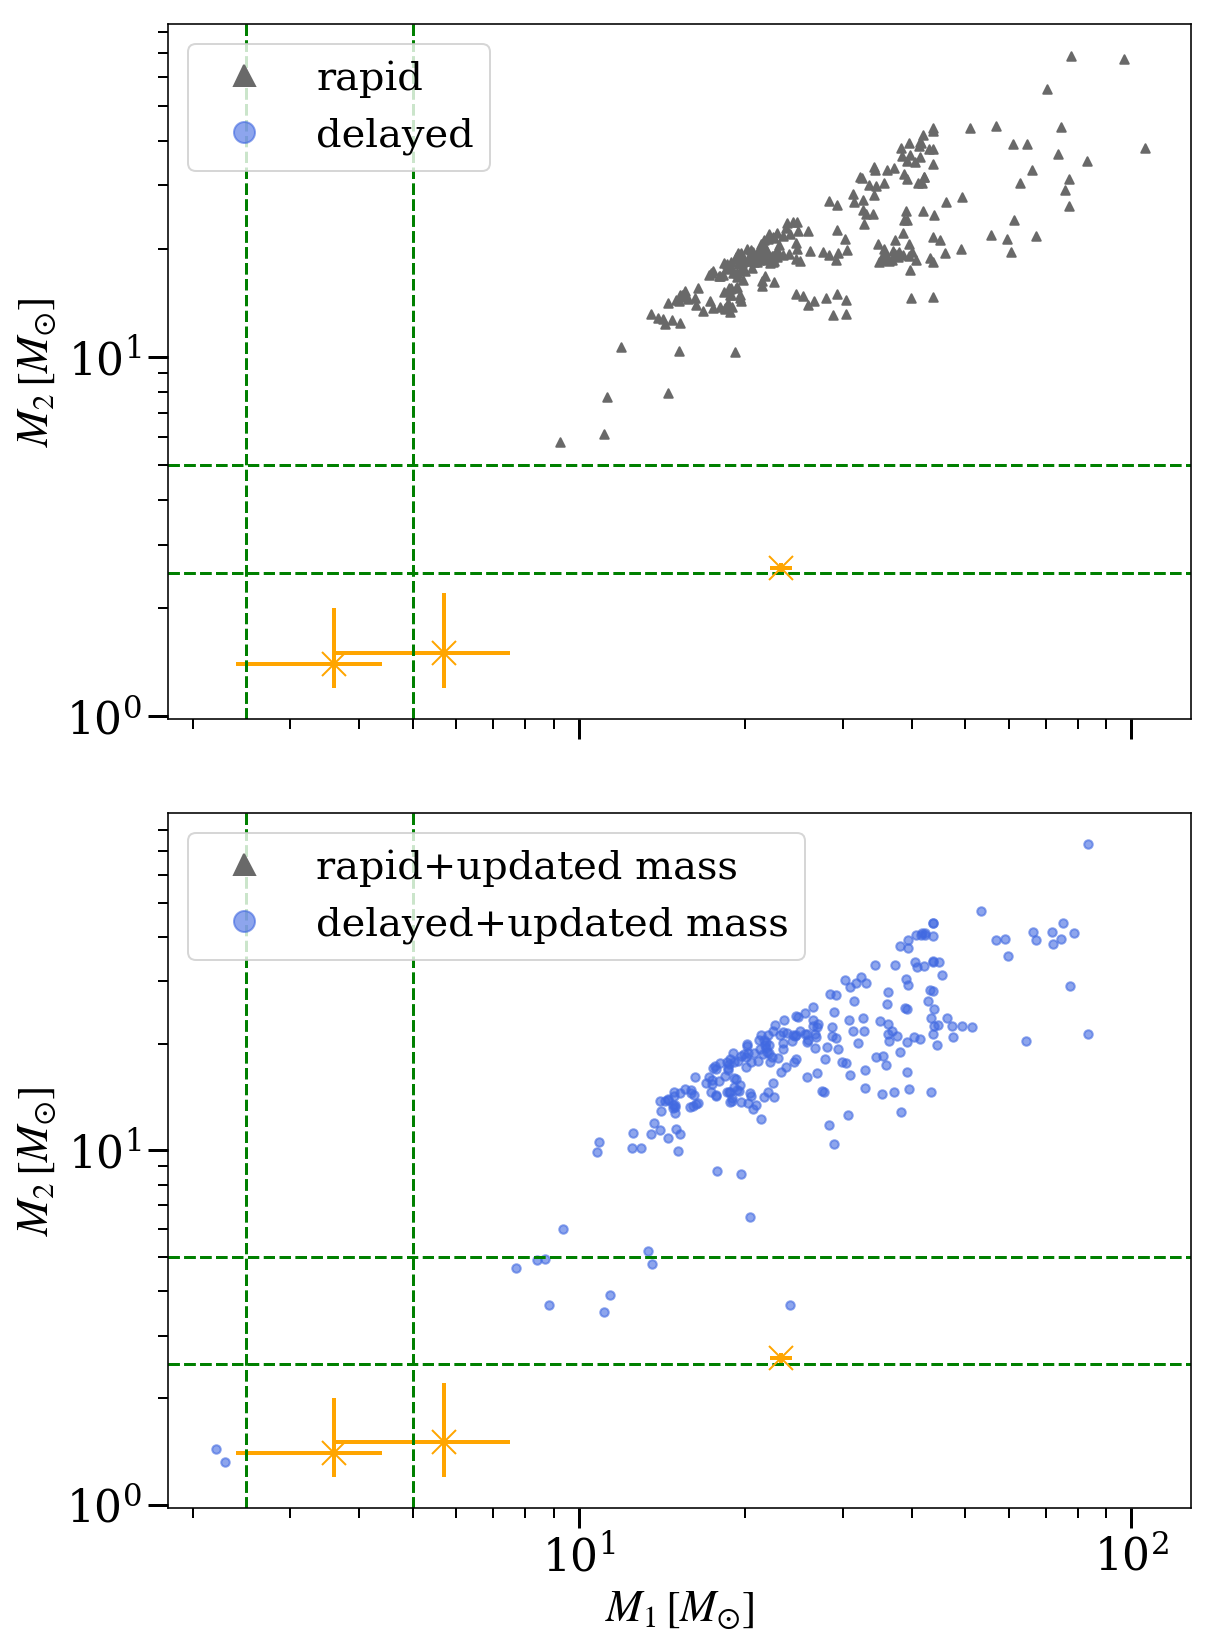

In [17]:
##NSBH and BBH mergers in models
##Observed mass-gap mergers
##GW230529, GW200115, GW190814
m0_gwobs = [3.6, 5.7, 23.2]; m1_gwobs = [1.4, 1.5, 2.59]
merr0_gwobs = [[1.2, 2.1, 1], [0.8, 1.8, 1.1]]; merr1_gwobs = [[0.2, 0.3, 0.09], [0.6, 0.7, 0.08]]


##Models
co_type = ['DNS', 'NSBH', 'BBH']

m0 = [[],[],[]]; m1 = [[],[],[]]; bbh_type = [[],[],[]]; id_all0 = [[],[],[]]; id_all1 = [[],[],[]] 
types_model = [[],[],[]]
M0 = [[],[],[]]; M1 = [[],[],[]]
id_mg0 = [[],[],[]]; id_mg1 = [[],[],[]] 
m_mg0 = [[],[],[]]; m_mg1 = [[],[],[]]
t_mg = [[],[],[]]

N_dns2bh = []
#cs = ['dimgray', 'orange', 'royalblue', 'crimson']
#labels = ['rapid', 'rapid+updated mass', 'delayed', 'delayed+updated mass']
btri_1=mlines.Line2D([], [],  linestyle = 'None', color='dimgray', marker='^',
                  markersize=7, alpha=1., label='rapid')
odot_1=mlines.Line2D([], [],  linestyle = 'None', color='royalblue', marker='o',
                  markersize=7, alpha=0.6, label='delayed')
btri_2=mlines.Line2D([], [],  linestyle = 'None', color='dimgray', marker='^',
                  markersize=7, alpha=1., label='rapid+updated mass')
odot_2=mlines.Line2D([], [],  linestyle = 'None', color='royalblue', marker='o',
                  markersize=7, alpha=0.6, label='delayed+updated mass')

fig, axs = plt.subplots(nrows=2, figsize=(9,12), sharex=True)
for xx in range(len(co_type)):
    for ii in range(len(paths)):
        ##To check how many mass-gap BHs come from DNS mergers
        m0_dns = []; m1_dns = []; type_dns = []; mm_dns = []
        
        #print(paths[ii])
        bbh_col = np.genfromtxt(paths[ii]+'GWcap_'+co_type[xx]+'.dat')
        #print(len(bbh_col))
        if len(bbh_col)>0:
            if len(bbh_col.shape)>1:
                three_col = bbh_col[:,12]
                m0[xx] = m0[xx]+list(bbh_col[:,10][three_col==-100])
                m1[xx] = m1[xx]+list(bbh_col[:,11][three_col==-100])
                bbh_type[xx] = bbh_type[xx]+list(np.full_like(bbh_col[:,10][three_col==-100], 1))
                types_model[xx]=types_model[xx]+list(np.full_like(bbh_col[:,10][three_col==-100], model_type[ii]))
                id_all0[xx].append(list(bbh_col[:,5][three_col==-100]))
                id_all1[xx].append(list(bbh_col[:,6][three_col==-100]))
                
                selec_crit0 = (bbh_col[:,10][three_col==-100]>=2.5) & (bbh_col[:,10][three_col==-100]<=5)
                selec_crit1 = (bbh_col[:,11][three_col==-100]>=2.5) & (bbh_col[:,11][three_col==-100]<=5)
                id_mg0[xx].append(list(bbh_col[:,5][three_col==-100][(selec_crit0) | (selec_crit1)]))
                id_mg1[xx].append(list(bbh_col[:,6][three_col==-100][(selec_crit0) | (selec_crit1)]))
                m_mg0[xx].append(list(bbh_col[:,10][three_col==-100][(selec_crit0) | (selec_crit1)]))
                m_mg1[xx].append(list(bbh_col[:,11][three_col==-100][(selec_crit0) | (selec_crit1)]))
                t_mg[xx].append(list(bbh_col[:,1][three_col==-100][(selec_crit0) | (selec_crit1)]))
                
                if xx==0:
                    m0_dns = m0_dns+list(bbh_col[:,10])
                    m1_dns = m1_dns+list(bbh_col[:,11])
                    type_dns = type_dns+list(np.full_like(bbh_col[:,10], 1))
                    mm_dns = mm_dns+list(bbh_col[:,9])
            else:
                #print(bbh_col)
                three_col = bbh_col[12]
                m0[xx] = m0[xx]+list(bbh_col[10][three_col==-100])
                m1[xx] = m1[xx]+list(bbh_col[11][three_col==-100])
                bbh_type[xx] = bbh_type[xx]+list(np.full_like(bbh_col[10][three_col==-100], 1))
                types_model[xx]=types_model[xx]+list(np.full_like(bbh_col[10][three_col==-100], model_type[ii]))
                id_all0[xx].append(list(bbh_col[5][three_col==-100]))
                id_all1[xx].append(list(bbh_col[6][three_col==-100]))
                
                selec_crit0 = (bbh_col[10][three_col==-100]>=2.5) & (bbh_col[10][three_col==-100]<=5)
                selec_crit1 = (bbh_col[11][three_col==-100]>=2.5) & (bbh_col[11][three_col==-100]<=5)
                id_mg0[xx].append(list(bbh_col[5][three_col==-100][(selec_crit0) | (selec_crit1)]))
                id_mg1[xx].append(list(bbh_col[6][three_col==-100][(selec_crit0) | (selec_crit1)]))
                m_mg0[xx].append(list(bbh_col[10][three_col==-100][(selec_crit0) | (selec_crit1)]))
                m_mg1[xx].append(list(bbh_col[11][three_col==-100][(selec_crit0) | (selec_crit1)]))
                t_mg[xx].append(list(bbh_col[1][three_col==-100][(selec_crit0) | (selec_crit1)]))
                
                if xx==0:
                    m0_dns = m0_dns+[bbh_col[10]]
                    m1_dns = m1_dns+[bbh_col[11]]
                    type_dns = type_dns+[np.full_like(bbh_col[10], 1)]
                    mm_dns = mm_dns+[bbh_col[9]]
                                     
        else:
            id_all0[xx].append([])
            id_all1[xx].append([])
            
            id_mg0[xx].append([])
            id_mg1[xx].append([])
            m_mg0[xx].append([])
            m_mg1[xx].append([])
            t_mg[xx].append([])
        
        bbh_mer = np.genfromtxt(paths[ii]+'Incluster_'+co_type[xx]+'.dat')
        if len(bbh_mer)>0 and len(bbh_mer.shape)>1:
            m0[xx] = m0[xx]+list(bbh_mer[:,7])
            m1[xx] = m1[xx]+list(bbh_mer[:,8])
            bbh_type[xx] = bbh_type[xx]+list(np.full_like(bbh_mer[:,7], 2))
            types_model[xx] = types_model[xx]+list(np.full_like(bbh_mer[:,7], model_type[ii]))
            id_all0[xx][ii] = id_all0[xx][ii]+list(bbh_mer[:,4])
            id_all1[xx][ii] = id_all1[xx][ii]+list(bbh_mer[:,5])
            
            selec_crit0 = (bbh_mer[:,7]>=2.5) & (bbh_mer[:,7]<=5)
            selec_crit1 = (bbh_mer[:,8]>=2.5) & (bbh_mer[:,8]<=5)
            id_mg0[xx][ii] = id_mg0[xx][ii]+list(bbh_mer[:,4][(selec_crit0) | (selec_crit1)])
            id_mg1[xx][ii] = id_mg1[xx][ii]+list(bbh_mer[:,5][(selec_crit0) | (selec_crit1)])
            m_mg0[xx][ii] = m_mg0[xx][ii]+list(bbh_mer[:,7][(selec_crit0) | (selec_crit1)])
            m_mg1[xx][ii] = m_mg1[xx][ii]+list(bbh_mer[:,8][(selec_crit0) | (selec_crit1)])
            t_mg[xx][ii] = t_mg[xx][ii]+list(bbh_mer[:,1][(selec_crit0) | (selec_crit1)])
        
            if xx==0:
                m0_dns = m0_dns+list(bbh_mer[:,7])
                m1_dns = m1_dns+list(bbh_mer[:,8])
                type_dns = type_dns+list(np.full_like(bbh_mer[:,7], 2))
                mm_dns = mm_dns+list(bbh_mer[:,6])
        
        elif len(bbh_mer)>0 and len(bbh_mer.shape)==1:
            m0[xx] = m0[xx]+[bbh_mer[7]]
            m1[xx] = m1[xx]+[bbh_mer[8]]
            bbh_type[xx] = bbh_type[xx]+[2]
            types_model[xx] = types_model[xx]+[model_type[ii]]
            id_all0[xx][ii] = id_all0[xx][ii]+[bbh_mer[4]]
            id_all1[xx][ii] = id_all1[xx][ii]+[bbh_mer[5]]
            
            selec_crit0 = (bbh_mer[7]>=2.5) & (bbh_mer[7]<=5)
            selec_crit1 = (bbh_mer[8]>=2.5) & (bbh_mer[8]<=5)
            id_mg0[xx][ii] = id_mg0[xx][ii]+list(bbh_mer[4][(selec_crit0) | (selec_crit1)])
            id_mg1[xx][ii] = id_mg1[xx][ii]+list(bbh_mer[5][(selec_crit0) | (selec_crit1)])
            m_mg0[xx][ii] = m_mg0[xx][ii]+list(bbh_mer[7][(selec_crit0) | (selec_crit1)])
            m_mg1[xx][ii] = m_mg1[xx][ii]+list(bbh_mer[8][(selec_crit0) | (selec_crit1)])
            t_mg[xx][ii] = t_mg[xx][ii]+list(bbh_mer[1][(selec_crit0) | (selec_crit1)])
        
            if xx==0:
                m0_dns = m0_dns+[bbh_mer[7]]
                m1_dns = m1_dns+[bbh_mer[8]]
                type_dns = type_dns+[2]
                mm_dns = mm_dns+[bbh_mer[6]]
        
        
        bbh_esc = np.genfromtxt(paths[ii]+'Esc_'+co_type[xx]+'.dat')
        if len(bbh_esc)>0:
            if len(bbh_esc.shape)>1:
                t_merger = bbh_esc[:,2]+bbh_esc[:,3]
                m0[xx]=m0[xx]+list(bbh_esc[:,4][t_merger<=14000.])
                m1[xx]=m1[xx]+list(bbh_esc[:,5][t_merger<=14000.])
                bbh_type[xx] = bbh_type[xx]+list(np.full_like(bbh_esc[:,4][t_merger<=14000.], 3))
                types_model[xx] = types_model[xx]+list(np.full_like(bbh_esc[:,4][t_merger<=14000.], model_type[ii]))
                id_all0[xx][ii] = id_all0[xx][ii]+list(bbh_esc[:,6][t_merger<=14000.])
                id_all1[xx][ii] = id_all1[xx][ii]+list(bbh_esc[:,7][t_merger<=14000.])
                
                selec_crit0 = (bbh_esc[:,4][t_merger<=14000.]>=2.5) & (bbh_esc[:,4][t_merger<=14000.]<=5)
                selec_crit1 = (bbh_esc[:,5][t_merger<=14000.]>=2.5) & (bbh_esc[:,5][t_merger<=14000.]<=5)
                id_mg0[xx][ii] = id_mg0[xx][ii]+list(bbh_esc[:,6][t_merger<=14000.][(selec_crit0) | (selec_crit1)])
                id_mg1[xx][ii] = id_mg1[xx][ii]+list(bbh_esc[:,7][t_merger<=14000.][(selec_crit0) | (selec_crit1)])
                m_mg0[xx][ii] = m_mg0[xx][ii]+list(bbh_esc[:,4][t_merger<=14000.][(selec_crit0) | (selec_crit1)])
                m_mg1[xx][ii] = m_mg1[xx][ii]+list(bbh_esc[:,5][t_merger<=14000.][(selec_crit0) | (selec_crit1)])
                t_mg[xx][ii] = t_mg[xx][ii]+list(bbh_esc[:,1][t_merger<=14000.][(selec_crit0) | (selec_crit1)])
                
                if xx==0:
                    m0_dns=m0_dns+list(bbh_esc[:,4][t_merger<=14000.])
                    m1_dns=m1_dns+list(bbh_esc[:,5][t_merger<=14000.])
                    type_dns = type_dns+list(np.full_like(bbh_esc[:,4][t_merger<=14000.], 3))
                    mm_dns = mm_dns+list(bbh_esc[:,4][t_merger<=14000.]+bbh_esc[:,5][t_merger<=14000.])
  
            else:
                t_merger = bbh_esc[2]+bbh_esc[3]
                m0[xx]=m0[xx]+list(bbh_esc[4][t_merger<=14000.])
                m1[xx]=m1[xx]+list(bbh_esc[5][t_merger<=14000.])
                bbh_type[xx] = bbh_type[xx]+list(np.full_like(bbh_esc[4][t_merger<=14000.], 3))
                types_model[xx] = types_model[xx]+list(np.full_like(bbh_esc[4][t_merger<=14000.], model_type[ii]))
                id_all0[xx][ii] = id_all0[xx][ii]+list(bbh_esc[6][t_merger<=14000.])
                id_all1[xx][ii] = id_all1[xx][ii]+list(bbh_esc[7][t_merger<=14000.])
                
                selec_crit0 = (bbh_esc[4][t_merger<=14000.]>=2.5) & (bbh_esc[4][t_merger<=14000.]<=5)
                selec_crit1 = (bbh_esc[5][t_merger<=14000.]>=2.5) & (bbh_esc[5][t_merger<=14000.]<=5)
                id_mg0[xx][ii] = id_mg0[xx][ii]+list(bbh_esc[6][t_merger<=14000.][(selec_crit0) | (selec_crit1)])
                id_mg1[xx][ii] = id_mg1[xx][ii]+list(bbh_esc[7][t_merger<=14000.][(selec_crit0) | (selec_crit1)])
                m_mg0[xx][ii] = m_mg0[xx][ii]+list(bbh_esc[4][t_merger<=14000.][(selec_crit0) | (selec_crit1)])
                m_mg1[xx][ii] = m_mg1[xx][ii]+list(bbh_esc[5][t_merger<=14000.][(selec_crit0) | (selec_crit1)])
                t_mg[xx][ii] = t_mg[xx][ii]+list(bbh_esc[1][t_merger<=14000.][(selec_crit0) | (selec_crit1)])
                
                if xx==0:
                    m0_dns=m0_dns+list(bbh_esc[4][t_merger<=14000.])
                    m1_dns=m1_dns+list(bbh_esc[5][t_merger<=14000.])
                    type_dns = type_dns+list(np.full_like(bbh_esc[4][t_merger<=14000.], 3))
                    mm_dns = mm_dns+list(bbh_esc[4][t_merger<=14000.]+bbh_esc[5][t_merger<=14000.])
        
        if xx==0:
            m0_dns = np.array(m0_dns); m1_dns = np.array(m1_dns)
            type_dns = np.array(type_dns)
            mm_dns = np.array(mm_dns)
    
            N_dns2bh.append(len(mm_dns[(mm_dns>2.5) & (type_dns!=3)]))
            
    
    M0[xx] = np.maximum(m0[xx],m1[xx])
    M1[xx] = np.minimum(m0[xx],m1[xx])
    types_model[xx] = np.array(types_model[xx])

    axs[0].scatter(M0[xx][types_model[xx]==1], M1[xx][types_model[xx]==1], marker='^',
                alpha=1., s=18, color = 'dimgray')
    axs[0].axhline(y=5, ls='--', color='green')
    axs[0].axvline(x=5, ls='--', color='green')
    axs[0].axhline(y=2.5, ls='--', color='green')
    axs[0].axvline(x=2.5, ls='--', color='green')
    
    axs[1].scatter(M0[xx][types_model[xx]==4], M1[xx][types_model[xx]==4],
                alpha=0.6, s=18, color='royalblue')
    axs[1].axhline(y=5, ls='--', color='green')
    axs[1].axvline(x=5, ls='--', color='green')
    axs[1].axhline(y=2.5, ls='--', color='green')
    axs[1].axvline(x=2.5, ls='--', color='green')
    
    
axs[0].errorbar(m0_gwobs, m1_gwobs, xerr = merr0_gwobs, yerr = merr1_gwobs,
                fmt='x', lw=2, markersize=12, color='orange')
axs[1].errorbar(m0_gwobs, m1_gwobs, xerr = merr0_gwobs, yerr = merr1_gwobs,
                fmt='x', lw=2, markersize=12, color='orange')
    
#axs[0].set_xlabel(r'$M_0\,[M_{\odot}]$')
axs[0].set_ylabel(r'$M_2\,[M_{\odot}]$')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].tick_params('both', length=10, width=1.5, which='major')
axs[0].tick_params('both', length=5, width=1, which='minor')
axs[0].legend(loc='upper left', fontsize=20, markerscale=1.5, handles=[btri_1, odot_1])

axs[1].set_xlabel(r'$M_1\,[M_{\odot}]$')
axs[1].set_ylabel(r'$M_2\,[M_{\odot}]$')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].tick_params('both', length=10, width=1.5, which='major')
axs[1].tick_params('both', length=5, width=1, which='minor')
axs[1].legend(loc='upper left', fontsize=20, markerscale=1.5, handles=[btri_2, odot_2])
fig.tight_layout()

#plt.savefig(savepath+'BBH_NSBH_DNS_masses.pdf', dpi=300)

print(type(id_all0[0]), type(id_all0))
print(id_mg0[1], id_mg1[1])

##Numbers(co_type = ['NSBH', 'BBH'])
for yy in range(2):
    print(yy)
    for xx in range(len(co_type)):
        Ms_r = M1[xx][types_model[xx]==(yy+1)];Mp_r = M0[xx][types_model[xx]==(yy+1)]
        Ms_d = M1[xx][types_model[xx]==(yy+3)];Mp_d = M0[xx][types_model[xx]==(yy+3)]
        
        if xx==0:
            print('NSBH', len(Ms_r), len(Ms_d), len(Ms_r[Mp_r<=5.]), len(Ms_d[Mp_d<=5]))
        if xx==1:
            print('BBH', len(Ms_r[Ms_r<=5.]), len(Ms_d[Ms_d<=5]), len(Ms_r[Mp_r<=5.]), len(Ms_d[Mp_d<=5]))

print('DNS to BH', N_dns2bh)

In [18]:
##NSWD mergers in models

##Models
N_nswd2bh = []

for ii in range(len(paths)):
    ##To check how many mass-gap BHs come from DNS mergers
    m0_nswd = []; m1_nswd = []; type_nswd = []
    mm_nswd = []
    
    #print(paths[ii])
    bbh_col = np.genfromtxt(paths[ii]+'GWcap_NSWD.dat')
    if len(bbh_col)>0:
        if len(bbh_col.shape)>1:
            three_col = bbh_col[:,12]
            m0_nswd = m0_nswd+list(bbh_col[:,10])
            m1_nswd = m1_nswd+list(bbh_col[:,11])
            type_nswd = type_nswd+list(np.full_like(bbh_col[:,10], 1))
            mm_nswd = mm_nswd+list(bbh_col[:,9])
        else:
            three_col = bbh_col[12]
            m0_nswd = m0_nswd+list(bbh_col[10])
            m1_nswd = m1_nswd+list(bbh_col[11])
            type_nswd = type_nswd+list(np.full_like(bbh_col[10], 1))
            mm_nswd = mm_nswd+list(bbh_col[9])
                
    bbh_mer = np.genfromtxt(paths[ii]+'Incluster_NSWD.dat')
    m0_nswd = m0_nswd+list(bbh_mer[:,7])
    m1_nswd = m1_nswd+list(bbh_mer[:,8])
    type_nswd = type_nswd+list(np.full_like(bbh_mer[:,7], 2))
    mm_nswd = mm_nswd+list(bbh_mer[:,6])
    
    bbh_esc = np.genfromtxt(paths[ii]+'Esc_NSWD.dat')
    if len(bbh_esc)>0:
        if len(bbh_esc.shape)>1:
            t_merger = bbh_esc[:,2]+bbh_esc[:,3]
            m0_nswd=m0_nswd+list(bbh_esc[:,4][t_merger<=14000.])
            m1_nswd=m1_nswd+list(bbh_esc[:,5][t_merger<=14000.])
            type_nswd = type_nswd+list(np.full_like(bbh_esc[:,4][t_merger<=14000.], 3))
            mm_nswd = mm_nswd+list(bbh_esc[:,4][t_merger<=14000.]+bbh_esc[:,5][t_merger<=14000.])

        else:
            t_merger = bbh_esc[2]+bbh_esc[3]
            m0_nswd=m0_nswd+list(bbh_esc[4][t_merger<=14000.])
            m1_nswd=m1_nswd+list(bbh_esc[5][t_merger<=14000.])
            type_nswd = type_nswd+list(np.full_like(bbh_esc[4][t_merger<=14000.], 3))
            mm_nswd = mm_nswd+list(bbh_esc[4][t_merger<=14000.]+bbh_esc[5][t_merger<=14000.])
    

    m0_nswd = np.array(m0_nswd); m1_nswd = np.array(m1_nswd)
    type_nswd = np.array(type_nswd)
    mm_nswd = np.array(mm_nswd)

    N_nswd2bh.append(len(mm_nswd[(mm_nswd>2.5) & (type_nswd!=3)]))
            
print('NSWD to BH', N_nswd2bh)

NSWD to BH [0, 21]


In [7]:
###Present-day DNS and NSBH binaries
###Include the ones that merge within a Hubble time

co_type = ['DNS', 'NSBH']

M0 = []; M1 = []
sma = []; ecc = []
B0 = []; B1 = []
spin0 = []; spin1 = []
btype = []; types_model = []
id_bin1 = []; id_bin2 = []
msp_flag1 = []; msp_flag2 = []

for xx in range(len(paths)):
    n_step = 0
    n1313 = 0; n1314 = 0
    
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    
    t_old = 14000.
    with open(paths[xx]+'initial.morepulsars.dat', 'r') as fpsr:
        next(fpsr)
        for line in fpsr:
            datapsr = line.split()
            if float(datapsr[1])*t_conv > 13000:
                break
            if float(datapsr[1])*t_conv < 10000:
                continue
            
            if float(datapsr[1])*t_conv > t_old:
                n_step+=1
                
            if int(datapsr[2])==1:
                if int(datapsr[11])==13 and int(datapsr[12])==13:
                    n1313+=1
                    
                    #if int(datapsr[3]) in id_all0[0][xx] and id_all1[0][xx][id_all0[0][xx].index(int(datapsr[3]))]==int(datapsr[4]):
                    ###id_all1 and id_all2 are the IDs of the compact object mergers
                    #    continue
                       
                    #if int(datapsr[4]) in id_all0[0][xx] and id_all1[0][xx][id_all0[0][xx].index(int(datapsr[4]))]==int(datapsr[3]):
                    #    continue
                    
                    if float(datapsr[5]) > float(datapsr[6]):
                        M0.append(float(datapsr[5])); M1.append(float(datapsr[6]))
                        btype.append(co_type[0]); types_model.append(model_type[xx])
                        sma.append(float(datapsr[13])); ecc.append(float(datapsr[14]))
                        B0.append(float(datapsr[7])); B1.append(float(datapsr[8]))
                        spin0.append(float(datapsr[9])); spin1.append(float(datapsr[10]))
                        id_bin1.append(int(datapsr[3])); id_bin2.append(int(datapsr[4]))
                        
                        if float(datapsr[7])>=(float(datapsr[9])**2)*(0.17*10**12) and float(datapsr[9])<=0.03:
                            msp_flag1.append(1)
                        else:
                            msp_flag1.append(0)
                            
                        if float(datapsr[8])>=(float(datapsr[10])**2)*(0.17*10**12) and float(datapsr[10])<=0.03:
                            msp_flag2.append(1)
                        else:
                            msp_flag2.append(0)

                        
                    else:
                        M0.append(float(datapsr[6])); M1.append(float(datapsr[5]))
                        btype.append(co_type[0]); types_model.append(model_type[xx])
                        sma.append(float(datapsr[13])); ecc.append(float(datapsr[14]))
                        B0.append(float(datapsr[8])); B1.append(float(datapsr[7]))
                        spin0.append(float(datapsr[10])); spin1.append(float(datapsr[9]))
                        id_bin1.append(int(datapsr[4])); id_bin2.append(int(datapsr[3]))
                        
                        if float(datapsr[8])>=(float(datapsr[10])**2)*(0.17*10**12) and float(datapsr[10])<=0.03:
                            msp_flag1.append(1)
                        else:
                            msp_flag1.append(0)
                            
                        if float(datapsr[7])>=(float(datapsr[9])**2)*(0.17*10**12) and float(datapsr[9])<=0.03:
                            msp_flag2.append(1)
                        else:
                            msp_flag2.append(0)
                    
                if int(datapsr[11])==14 and int(datapsr[12])==13:
                    n1314+=1
                    #if int(datapsr[3]) in id_all0[1][xx] and id_all1[1][xx][id_all0[1][xx].index(int(datapsr[3]))]==int(datapsr[4]):
                    #    continue
                       
                    #if int(datapsr[4]) in id_all0[1][xx] and id_all1[1][xx][id_all0[1][xx].index(int(datapsr[4]))]==int(datapsr[3]):
                    #    continue
                        
                    M0.append(float(datapsr[5])); M1.append(float(datapsr[6]))
                    btype.append(co_type[1]); types_model.append(model_type[xx])
                    sma.append(float(datapsr[13])); ecc.append(float(datapsr[14]))
                    B0.append(float(datapsr[7])); B1.append(float(datapsr[8]))
                    spin0.append(float(datapsr[9])); spin1.append(float(datapsr[10]))
                    id_bin1.append(int(datapsr[3])); id_bin2.append(int(datapsr[4]))
                    
                    if float(datapsr[8])>=(float(datapsr[10])**2)*(0.17*10**12) and float(datapsr[10])<=0.03:
                        msp_flag2.append(1)
                    else:
                        msp_flag2.append(0)
                        
                    msp_flag1.append(-100)
                        
                if int(datapsr[11])==13 and int(datapsr[12])==14:
                    n1314+=1
                    #if int(datapsr[3]) in id_all0[1][xx] and id_all1[1][xx][id_all0[1][xx].index(int(datapsr[3]))]==int(datapsr[4]):
                    #    continue
                       
                    #if int(datapsr[4]) in id_all0[1][xx] and id_all1[1][xx][id_all0[1][xx].index(int(datapsr[4]))]==int(datapsr[3]):
                    #    continue
                        
                    M0.append(float(datapsr[6])); M1.append(float(datapsr[5]))
                    btype.append(co_type[1]); types_model.append(model_type[xx])
                    sma.append(float(datapsr[13])); ecc.append(float(datapsr[14]))
                    B0.append(float(datapsr[8])); B1.append(float(datapsr[7]))
                    spin0.append(float(datapsr[10])); spin1.append(float(datapsr[9]))
                    id_bin1.append(int(datapsr[4])); id_bin2.append(int(datapsr[3]))
                    
                    if float(datapsr[7])>=(float(datapsr[9])**2)*(0.17*10**12) and float(datapsr[9])<=0.03:
                        msp_flag2.append(1)
                    else:
                        msp_flag2.append(0)
                        
                    msp_flag1.append(-100)
            
            t_old = float(datapsr[1])*t_conv
            
    print(n_step)
    print('# of DNS', n_step, n1313/n_step, n1314/n_step)
                    
M0 = np.array(M0); M1 = np.array(M1)
types_model = np.array(types_model)
sma = np.array(sma); ecc = np.array(ecc)
msp_flag1 = np.array(msp_flag1); msp_flag2 = np.array(msp_flag2)
print(len(M0), len(M0[(types_model=='1') | (types_model=='3')]), len(M0[(types_model=='2') | (types_model=='4')]))

47
# of DNS 47 0.06382978723404255 0.23404255319148937
198
# of DNS 198 0.9292929292929293 1.0252525252525253
401 14 387


22.598138
493.8489409967227 13.208480950220414 0.6696873101834625 0.70924406
87.14916938351573 0.7621903575172566 0.938068288 0.324380506
387 166
67 67
32.555565861092084 13.208480950220414
0.7046859568656716 0.70744422


(array([ 7.,  2.,  2.,  0.,  1.,  3.,  2.,  2.,  2., 15.,  6.,  6.,  4.,
         7.,  8.]),
 array([0.30027804, 0.34490351, 0.38952899, 0.43415446, 0.47877993,
        0.5234054 , 0.56803088, 0.61265635, 0.65728182, 0.70190729,
        0.74653277, 0.79115824, 0.83578371, 0.88040918, 0.92503466,
        0.96966013]),
 <a list of 15 Patch objects>)

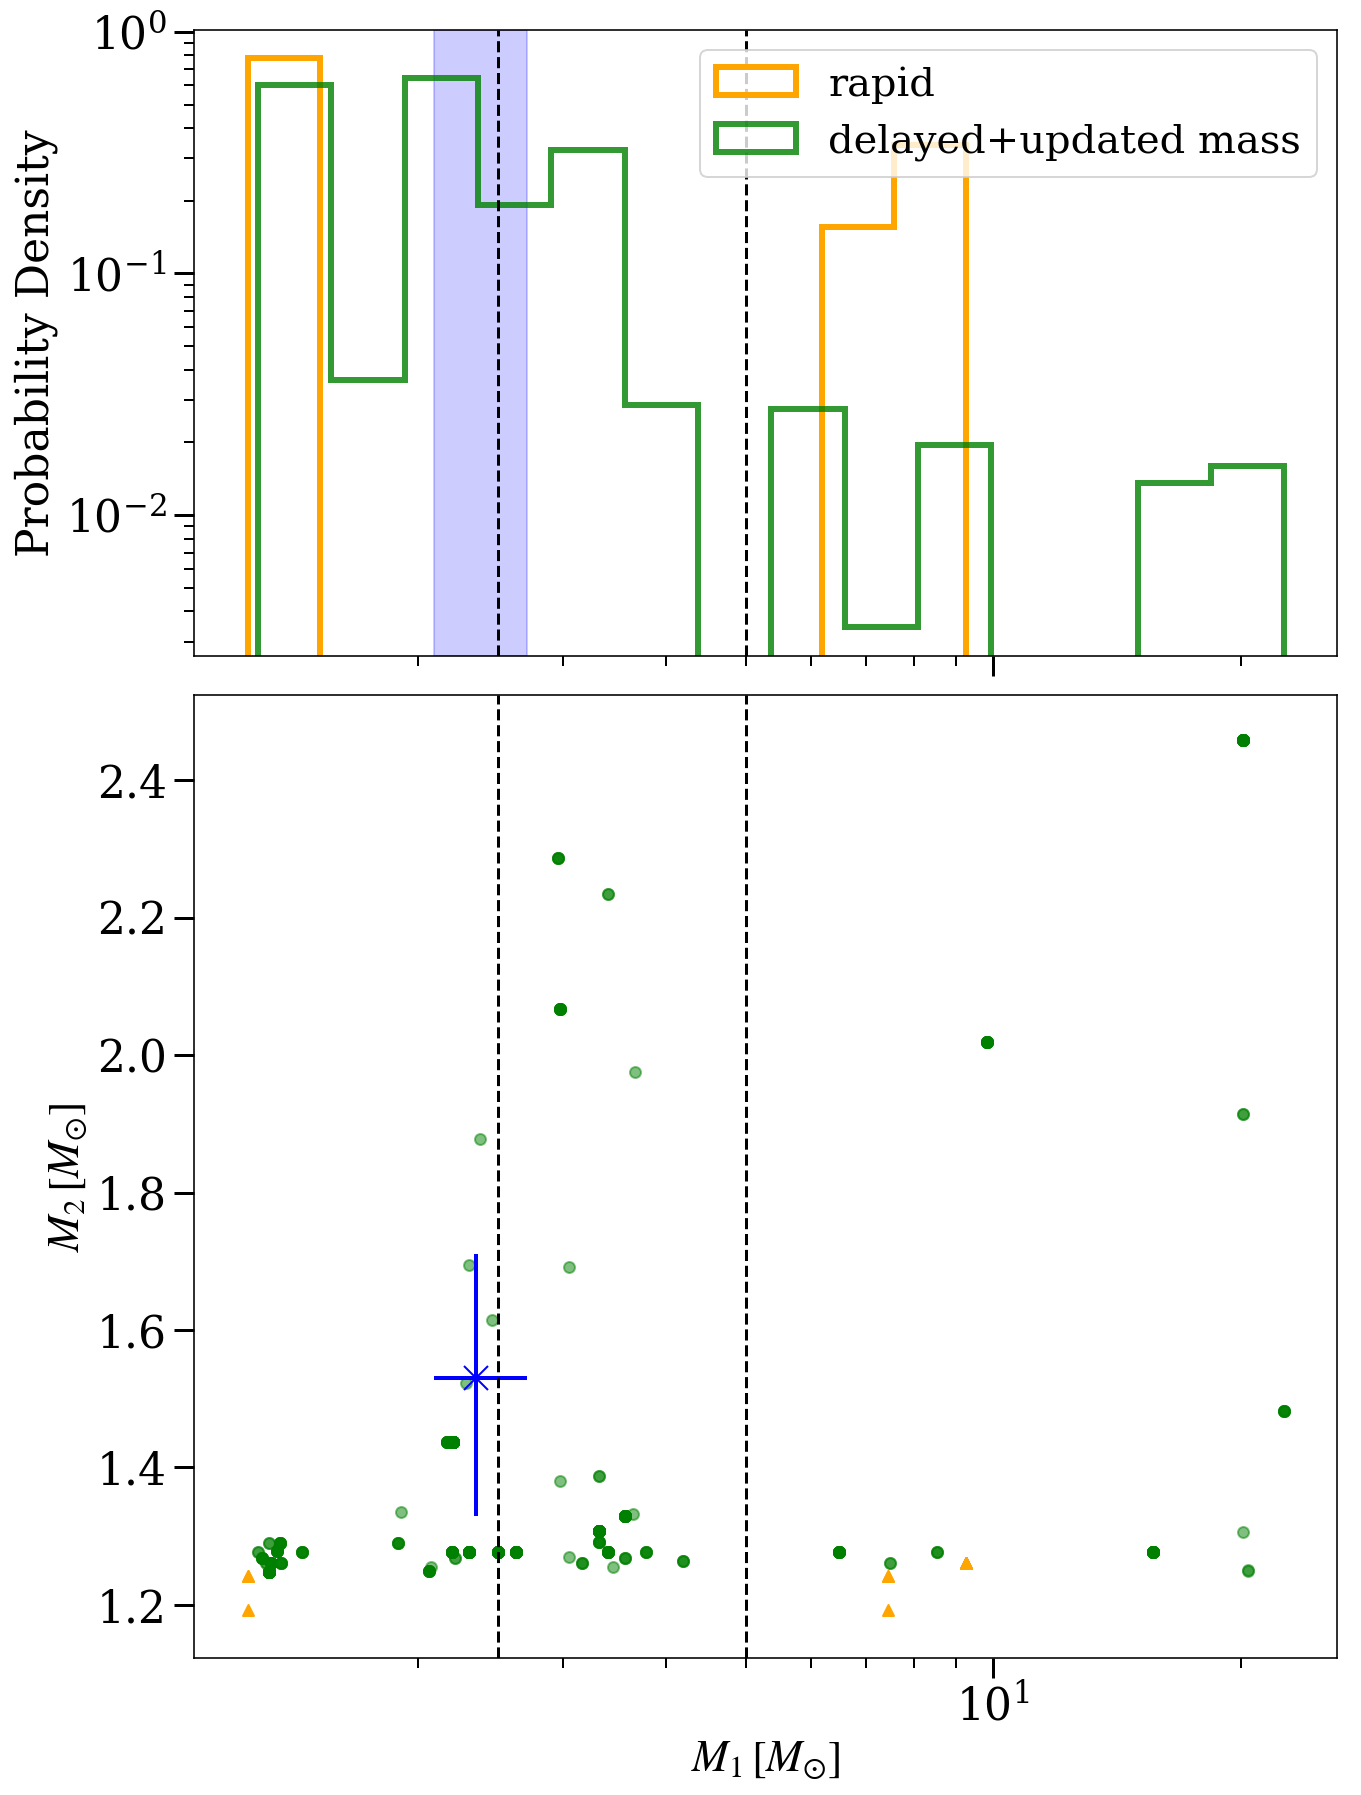

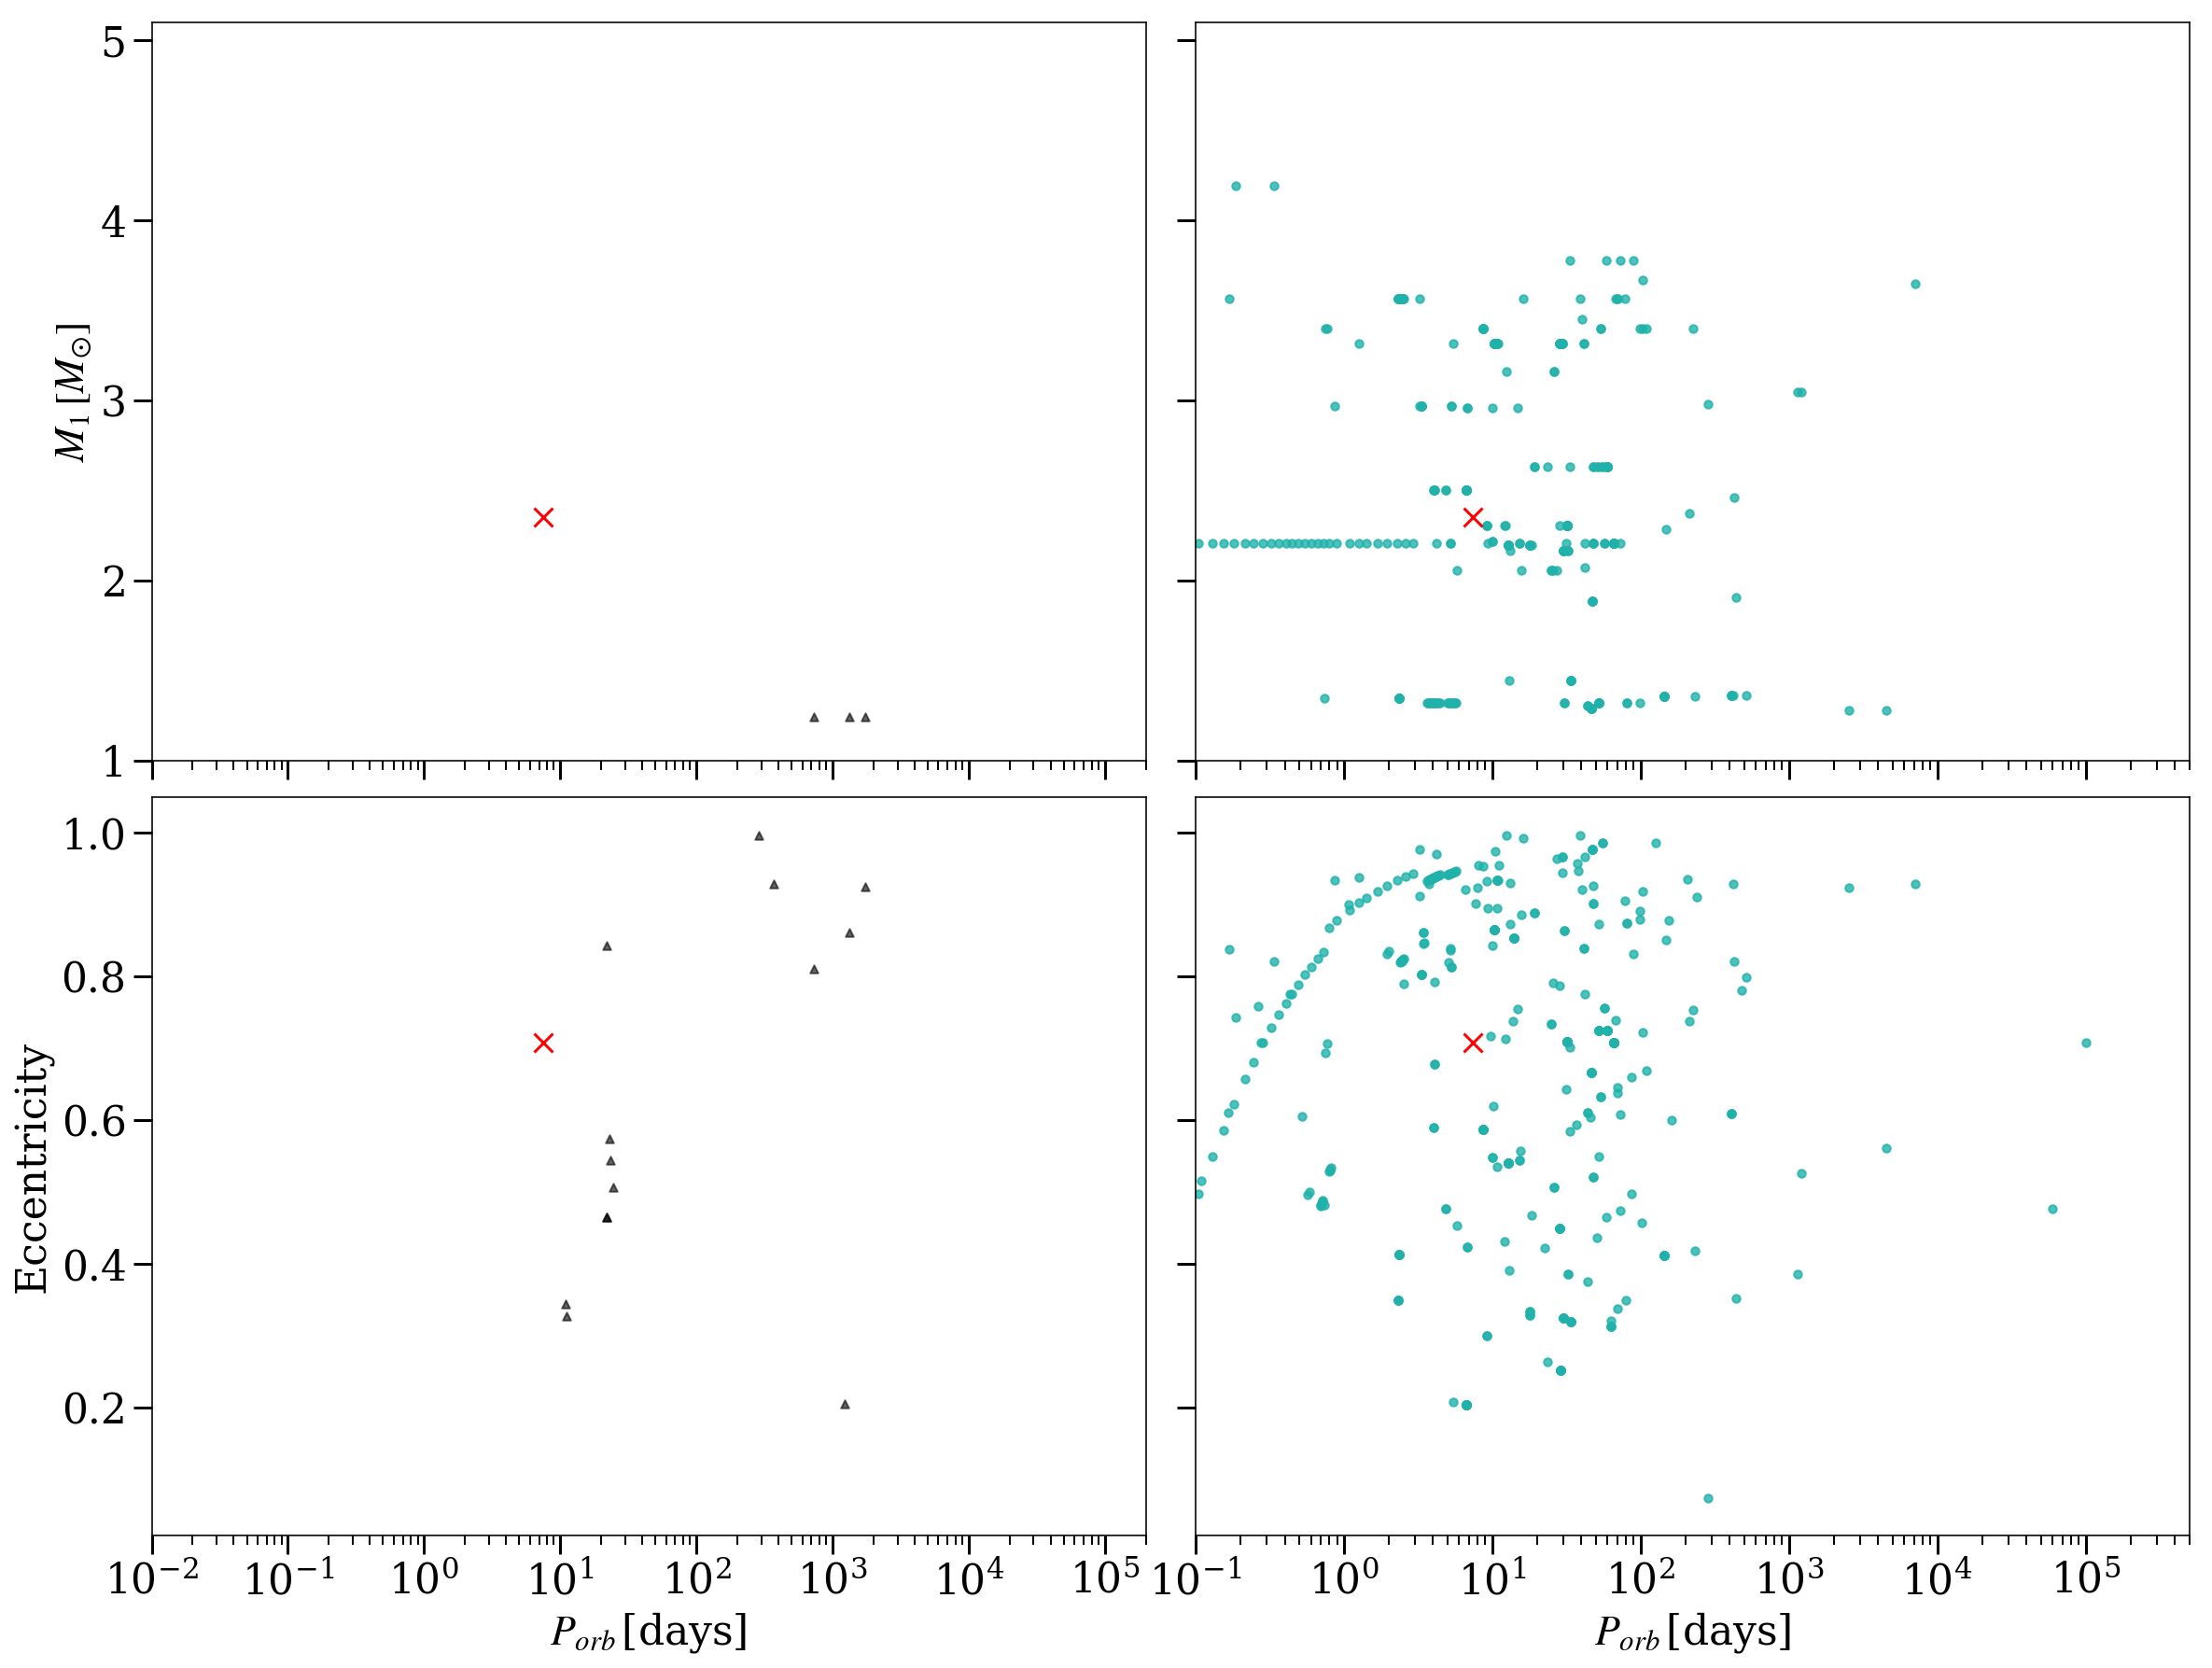

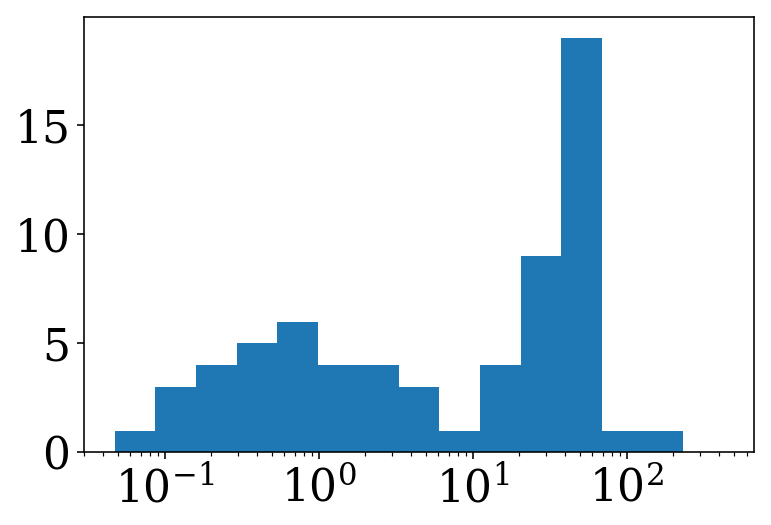

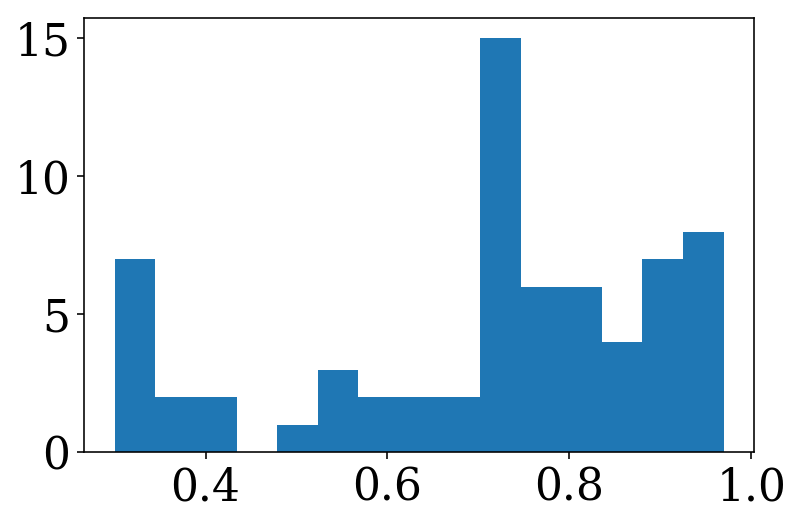

In [19]:
#print(types_model)
print(np.max(M0))

sma_day = uc.au_to_period(sma, M0, M1)

######Observations######
M0_obs = [2.35,]; M1_obs = [1.53,]
M0err_obs = [[0.26,],[0.36,]]
M1err_obs = [[0.2,],[0.18,]]
sma_obs = [7.448]  ##days
ecc_obs = [0.708]



##Plotting present-day DNS and NSBH
btri_1=mlines.Line2D([], [],  linestyle = 'None', color='orange', marker='^',
                  markersize=7, alpha=1., label='rapid')
odot_1=mlines.Line2D([], [],  linestyle = 'None', color='green', marker='o',
                  markersize=7, alpha=0.8, label='delayed+updated mass')

fig, axs = plt.subplots(nrows=2, figsize=(10,13), sharex=True,
                       gridspec_kw={'height_ratios': [1.3, 2]})                    
axs[1].scatter(M0[types_model=='1'], M1[types_model=='1'], marker='^',# facecolor='none',
                alpha=1., s=30, color = 'orange')
axs[1].scatter(M0[types_model=='4'], M1[types_model=='4'], marker='o',# facecolor='none',
                alpha=0.5, s=30, color = 'green')
axs[1].axvline(x=5, ls='--', color='k')
axs[1].axvline(x=2.5, ls='--', color='k')

axs[0].hist(M0[types_model=='1'], 
               bins=np.logspace(np.log10(np.min(M0[types_model=='1'])), np.log10(np.max(M0[types_model=='1'])),11),
                alpha=1., color = 'orange', histtype='step', lw=3, zorder=2,
            density=True,
            label='rapid')
axs[0].hist(M0[types_model=='4'], 
               bins=np.logspace(np.log10(np.min(M0[types_model=='4'])), np.log10(np.max(M0[types_model=='4'])),15),
                alpha=0.8, color = 'green', histtype='step', lw=3, zorder=2,
            density=True,
            label='delayed+updated mass')
axs[0].axvline(x=5, ls='--', color='k')
axs[0].axvline(x=2.5, ls='--', color='k')


axs[1].errorbar(M0_obs, M1_obs, xerr = M0err_obs, yerr = M1err_obs,
                fmt='x', lw=2, markersize=12, color='b')

axs[0].axvspan((np.array(M0_obs)-np.array(M0err_obs)[0][0])[0], 
                    (np.array(M0_obs)+np.array(M0err_obs)[1][0])[0], color='b', alpha=0.2,zorder=1)

axs[1].set_ylabel(r'$M_2\,[M_{\odot}]$')
axs[1].set_xlabel(r'$M_1\,[M_{\odot}]$')
axs[1].set_xscale('log')
axs[1].tick_params('both', length=10, width=1.5, which='major')
axs[1].tick_params('both', length=5, width=1, which='minor')


axs[0].set_yscale('log')
axs[0].tick_params('both', length=10, width=1.5, which='major')
axs[0].tick_params('both', length=5, width=1, which='minor')
axs[0].set_ylabel('Probability Density')
axs[0].legend(loc='upper right', fontsize=20)

fig.tight_layout()
plt.subplots_adjust(hspace=0.05)
##plt.savefig(savepath+'dns_nsbh_m1_m2_1851.pdf', dpi=300)


############################################################################
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(17,13), sharex='col', sharey='row')                    
axs[1][0].scatter(sma_day[types_model=='1'], ecc[types_model=='1'], marker='^',
                  alpha=0.6, s=18, color = 'k')
axs[1][0].scatter(sma_obs, ecc_obs, marker='x', s=100, c='red')

axs[1][1].scatter(sma_day[types_model=='4'], ecc[types_model=='4'],
                  alpha=0.8, s=18, color='lightseagreen')
axs[1][1].scatter(sma_obs, ecc_obs, marker='x', s=100, c='red')

axs[0][0].scatter(sma_day[types_model=='1'], M0[types_model=='1'],
                  marker='^',alpha=0.6, s=18, color = 'k')
axs[0][0].scatter(sma_obs, M0_obs, marker='x', s=100, c='red')

axs[0][1].scatter(sma_day[types_model=='4'], M0[types_model=='4'],
                  alpha=0.8, s=18, color='lightseagreen')
axs[0][1].scatter(sma_obs, M0_obs, marker='x', s=100, c='red')


axs[0][0].tick_params('both', length=10, width=1.5, which='major')
axs[0][0].tick_params('both', length=5, width=1, which='minor')
axs[0][0].set_ylabel(r'$M_1\,[M_{\odot}]$')

axs[0][1].tick_params('both', length=10, width=1.5, which='major')
axs[0][1].tick_params('both', length=5, width=1, which='minor')
    
axs[1][0].set_xlabel(r'$P_{orb}\,$[days]')
axs[1][0].set_ylabel('Eccentricity')
axs[1][0].set_xscale('log')
axs[1][0].set_xlim(xmin = 0.01, xmax=200000)
axs[1][0].tick_params('both', length=10, width=1.5, which='major')
axs[1][0].tick_params('both', length=5, width=1, which='minor')
#axs[0].legend(loc='upper left', fontsize=20, markerscale=1.5, handles=[btri_1, odot_1])

axs[1][1].set_xlabel(r'$P_{orb}\,$[days]')
axs[1][1].set_xscale('log')
axs[1][1].set_xlim(xmin = 0.1, xmax=500000)
axs[1][1].tick_params('both', length=10, width=1.5, which='major')
axs[1][1].tick_params('both', length=5, width=1, which='minor')
#axs[1].legend(loc='upper left', fontsize=20, markerscale=1.5, handles=[btri_2, odot_2])

axs[0][0].set_ylim(ymin=1.,ymax=5.1)
#axs[0][1].set_yscale('log')

fig.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)

###Some values for orbital periods and eccentricities
sma_day_1851 = sma_day[types_model=='4']; ecc_1851 = ecc[types_model=='4']
m0_1851 = M0[types_model=='4']; m1_1851 = M1[types_model=='4']
print(np.mean(sma_day_1851), np.median(sma_day_1851), 
      np.mean(ecc_1851), np.median(ecc_1851))
print(np.percentile(sma_day_1851, 90), np.percentile(sma_day_1851, 10),
      np.percentile(ecc_1851, 90), np.percentile(ecc_1851, 10))
print(len(sma_day_1851), len(sma_day_1851[(sma_day_1851>=1.) & ((sma_day_1851<=20.))]))
####Mass gap orbital periods and eccentricities
sma_mg = sma_day_1851[(m0_1851>=2.09) & (m0_1851<=2.71) & (m1_1851>=1.3) & (m1_1851<=1.75)]
ecc_mg = ecc_1851[(m0_1851>=2.09) & (m0_1851<=2.71) & (m1_1851>=1.3) & (m1_1851<=1.75)]
print(len(sma_mg), len(ecc_mg))
print(np.mean(sma_mg), np.median(sma_mg))
print(np.mean(ecc_mg), np.median(ecc_mg))

plt.figure()
plt.hist(sma_mg,
         bins=np.logspace(np.min(np.log10(sma_mg)), np.max(np.log10(sma_mg)), 16))
plt.xscale('log')

plt.figure()
plt.hist(ecc_mg, bins=15)

In [6]:
###Present-day DNS and NSBH binaries
##Fraction of NSBH binaries containing mass gaps

co_type = ['DNS', 'NSBH']

F_mg_nsbh = []

for xx in range(len(paths)):
    M0 = []; M1 = []
    sma = []; ecc = []
    B0 = []; B1 = []
    spin0 = []; spin1 = []
    btype = []; types_model = []
    id_bin1 = []; id_bin2 = []
    msp_flag1 = []; msp_flag2 = []
    t_myr = []
    
    Frac_mg_nsbh_model = []

    mg_step = [[0],[0]]
    n_step = 1
    msp_step = [[0],[0]]
    
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    
    t_old = 14000.
    with open(paths[xx]+'initial.morepulsars.dat', 'r') as fpsr:
        next(fpsr)
        for line in fpsr:
            datapsr = line.split()
            if float(datapsr[1])*t_conv > 13000:
                break
            if float(datapsr[1])*t_conv < 10000:
                continue
            
            if float(datapsr[1])*t_conv > t_old:
                n_step+=1
                mg_step[0].append(0); mg_step[1].append(0)
                msp_step[0].append(0); msp_step[1].append(0)
            
            if int(datapsr[2])==1:
                if int(datapsr[11])==13 and int(datapsr[12])==13:
                    if 2.<float(datapsr[5])<5. or 2.<float(datapsr[6])<5.:
                        mg_step[1][-1]=1
                            
                        if float(datapsr[7])>=(float(datapsr[9])**2)*(0.17*10**12) and float(datapsr[9])<=0.03:
                            msp_step[1][-1]=1
                        
                        elif float(datapsr[8])>=(float(datapsr[10])**2)*(0.17*10**12) and float(datapsr[10])<=0.03:
                            msp_step[1][-1]=1
                        
                        elif int(datapsr[3]) in idtde_all[xx] or int(datapsr[3]) in idtde_latercoll_all[xx]:
                            msp_step[1][-1]=1
                            
                        elif int(datapsr[4]) in idtde_all[xx] or int(datapsr[4]) in idtde_latercoll_all[xx]:
                            msp_step[1][-1]=1
                    
                    ###This exclude the ones that merge in a Hubble time###
                    #if int(datapsr[3]) in id_all0[0][xx] and id_all1[0][xx][id_all0[0][xx].index(int(datapsr[3]))]==int(datapsr[4]):
                    ###id_all1 and id_all2 are the IDs of the compact object mergers
                    #    continue
                       
                    #if int(datapsr[4]) in id_all0[0][xx] and id_all1[0][xx][id_all0[0][xx].index(int(datapsr[4]))]==int(datapsr[3]):
                    #    continue
                    
                    if float(datapsr[5]) > float(datapsr[6]):
                        M0.append(float(datapsr[5])); M1.append(float(datapsr[6]))
                        btype.append(co_type[0]); types_model.append(model_type[xx])
                        sma.append(float(datapsr[13])); ecc.append(float(datapsr[14]))
                        B0.append(float(datapsr[7])); B1.append(float(datapsr[8]))
                        spin0.append(float(datapsr[9])); spin1.append(float(datapsr[10]))
                        id_bin1.append(int(datapsr[3])); id_bin2.append(int(datapsr[4]))
                        t_myr.append(float(datapsr[1])*t_conv)
                        
                        if float(datapsr[7])>=(float(datapsr[9])**2)*(0.17*10**12) and float(datapsr[9])<=0.03:
                            msp_flag1.append(1)
                        elif int(datapsr[3]) in idtde_all[xx] or int(datapsr[3]) in idtde_latercoll_all[xx]:
                            msp_flag1.append(1)
                        else:
                            msp_flag1.append(0)
                            
                        if float(datapsr[8])>=(float(datapsr[10])**2)*(0.17*10**12) and float(datapsr[10])<=0.03:
                            msp_flag2.append(1)
                        elif int(datapsr[4]) in idtde_all[xx] or int(datapsr[4]) in idtde_latercoll_all[xx]:
                            msp_flag2.append(1)
                        else:
                            msp_flag2.append(0)

                        
                    else:
                        M0.append(float(datapsr[6])); M1.append(float(datapsr[5]))
                        btype.append(co_type[0]); types_model.append(model_type[xx])
                        sma.append(float(datapsr[13])); ecc.append(float(datapsr[14]))
                        B0.append(float(datapsr[8])); B1.append(float(datapsr[7]))
                        spin0.append(float(datapsr[10])); spin1.append(float(datapsr[9]))
                        id_bin1.append(int(datapsr[4])); id_bin2.append(int(datapsr[3]))
                        t_myr.append(float(datapsr[1])*t_conv)
                        
                        if float(datapsr[8])>=(float(datapsr[10])**2)*(0.17*10**12) and float(datapsr[10])<=0.03:
                            msp_flag1.append(1)
                        elif int(datapsr[4]) in idtde_all[xx] or int(datapsr[4]) in idtde_latercoll_all[xx]:    
                            msp_flag1.append(1)
                        else:
                            msp_flag1.append(0)
                            
                        if float(datapsr[7])>=(float(datapsr[9])**2)*(0.17*10**12) and float(datapsr[9])<=0.03:
                            msp_flag2.append(1)
                        elif int(datapsr[3]) in idtde_all[xx] or int(datapsr[3]) in idtde_latercoll_all[xx]:
                            msp_flag2.append(1)
                        else:
                            msp_flag2.append(0)
                    
                if int(datapsr[11])==14 and int(datapsr[12])==13:
                    if 2.5<float(datapsr[5])<5.:
                        mg_step[0][-1]=1
                
                        if float(datapsr[8])>=(float(datapsr[10])**2)*(0.17*10**12) and float(datapsr[10])<=0.03:
                            msp_step[0][-1]=1
                            
                        elif int(datapsr[4]) in idtde_all[xx] or int(datapsr[4]) in idtde_latercoll_all[xx]:
                            msp_step[0][-1]=1
                
                    if 2.<float(datapsr[5])<5. or 2.<float(datapsr[6])<5.:
                        mg_step[1][-1]=1
                            
                        if float(datapsr[8])>=(float(datapsr[10])**2)*(0.17*10**12) and float(datapsr[10])<=0.03:
                            msp_step[1][-1]=1
                            
                        elif int(datapsr[4]) in idtde_all[xx] or int(datapsr[4]) in idtde_latercoll_all[xx]:
                            msp_step[1][-1]=1
                    
                    ###This exclude the ones that merge in a Hubble time###
                    #if int(datapsr[3]) in id_all0[1][xx] and id_all1[1][xx][id_all0[1][xx].index(int(datapsr[3]))]==int(datapsr[4]):
                    #    continue
                       
                    #if int(datapsr[4]) in id_all0[1][xx] and id_all1[1][xx][id_all0[1][xx].index(int(datapsr[4]))]==int(datapsr[3]):
                    #    continue
                        
                    M0.append(float(datapsr[5])); M1.append(float(datapsr[6]))
                    btype.append(co_type[1]); types_model.append(model_type[xx])
                    sma.append(float(datapsr[13])); ecc.append(float(datapsr[14]))
                    B0.append(float(datapsr[7])); B1.append(float(datapsr[8]))
                    spin0.append(float(datapsr[9])); spin1.append(float(datapsr[10]))
                    id_bin1.append(int(datapsr[3])); id_bin2.append(int(datapsr[4]))
                    t_myr.append(float(datapsr[1])*t_conv)
                    
                    if float(datapsr[8])>=(float(datapsr[10])**2)*(0.17*10**12) and float(datapsr[10])<=0.03:
                        msp_flag2.append(1)
                    elif int(datapsr[4]) in idtde_all[xx] or int(datapsr[4]) in idtde_latercoll_all[xx]:    
                        msp_flag2.append(1)
                    else:
                        msp_flag2.append(0)
                        
                    msp_flag1.append(-100)
                        
                if int(datapsr[11])==13 and int(datapsr[12])==14:
                    if 2.5<float(datapsr[6])<5.:
                        mg_step[0][-1]=1
                            
                        if float(datapsr[7])>=(float(datapsr[9])**2)*(0.17*10**12) and float(datapsr[9])<=0.03:
                            msp_step[0][-1]=1
                            
                        elif int(datapsr[3]) in idtde_all[xx] or int(datapsr[3]) in idtde_latercoll_all[xx]:
                            msp_step[0][-1]=1
                
                    if 2.<float(datapsr[5])<5. or 2.<float(datapsr[6])<5.:
                        mg_step[1][-1]=1
                            
                        if float(datapsr[7])>=(float(datapsr[9])**2)*(0.17*10**12) and float(datapsr[9])<=0.03:
                            msp_step[1][-1]=1
                            
                        elif int(datapsr[3]) in idtde_all[xx] or int(datapsr[3]) in idtde_latercoll_all[xx]:
                            msp_step[1][-1]=1
                        
                    #if int(datapsr[3]) in id_all0[1][xx] and id_all1[1][xx][id_all0[1][xx].index(int(datapsr[3]))]==int(datapsr[4]):
                    #    continue
                       
                    #if int(datapsr[4]) in id_all0[1][xx] and id_all1[1][xx][id_all0[1][xx].index(int(datapsr[4]))]==int(datapsr[3]):
                    #    continue
                        
                    M0.append(float(datapsr[6])); M1.append(float(datapsr[5]))
                    btype.append(co_type[1]); types_model.append(model_type[xx])
                    sma.append(float(datapsr[13])); ecc.append(float(datapsr[14]))
                    B0.append(float(datapsr[8])); B1.append(float(datapsr[7]))
                    spin0.append(float(datapsr[10])); spin1.append(float(datapsr[9]))
                    id_bin1.append(int(datapsr[4])); id_bin2.append(int(datapsr[3]))
                    t_myr.append(float(datapsr[1])*t_conv)
                    
                    if float(datapsr[7])>=(float(datapsr[9])**2)*(0.17*10**12) and float(datapsr[9])<=0.03:
                        msp_flag2.append(1)
                    elif int(datapsr[3]) in idtde_all[xx] or int(datapsr[3]) in idtde_latercoll_all[xx]:
                        msp_flag2.append(1)
                    else:
                        msp_flag2.append(0)
                        
                    msp_flag1.append(-100)
            
            t_old = float(datapsr[1])*t_conv
            


    
    M0 = np.array(M0); M1 = np.array(M1)
    types_model = np.array(types_model)
    btype = np.array(btype)
    sma = np.array(sma); ecc = np.array(ecc)
    msp_flag1 = np.array(msp_flag1); msp_flag2 = np.array(msp_flag2)
    t_myr = np.array(t_myr)
    
    #print(M0[btype=='NSBH'], M1[btype=='NSBH'])

    print(xx, paths[xx], '\n', np.sum(mg_step[0])/n_step, np.sum(mg_step[1])/n_step, 
          np.sum(msp_step[0])/n_step, np.sum(msp_step[1])/n_step, n_step)
    print('\n', len(M1[(M0>2.5) & (M0<5.)])/len(M1), len(M1[(M0>2.) & (M0<5.)])/len(M1), len(M1))
    print(M0[(M0>2.) & (M0<5.) & (msp_flag2==1)], M1[(M0>2.) & (M0<5.) & (msp_flag2==1)])
    F_mg_nsbh.append(len(M1[(M0>2.5) & (M0<5.)])/len(M1))
    
    print(np.stack((M0, M1), axis=-1))

0 /projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc1851/N1.3e6rv0.5z0.0013rg20/ 
 0.0 0.0 0.0 0.0 48

 0.0 0.0 14
[] []
[[1.242     1.242    ]
 [1.242     1.242    ]
 [9.2557324 1.2607821]
 [9.2557324 1.2607821]
 [9.2557324 1.2607821]
 [9.2557324 1.2607821]
 [9.2557324 1.2607821]
 [9.2557324 1.2607821]
 [9.2557324 1.2607821]
 [9.2557324 1.2607821]
 [7.4580567 1.242    ]
 [7.4580567 1.242    ]
 [7.4580567 1.1932174]
 [1.2420689 1.1932174]]
1 /projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc1851/N1.3e6rv0.5z0.0013rg20_wdtc_wdmass_qcrit4_delay/ 
 0.507537688442211 0.6683417085427136 0.2914572864321608 0.4271356783919598 199

 0.3359173126614987 0.6227390180878553 387
[3.3187604 3.3187604 3.3187604 3.3187604 3.3187604 3.3187604 3.3187604
 3.3187604 3.3187604 3.3187604 3.3187604 3.3187604 3.3187604 3.3187604
 3.3187604 3.3187604 3.3187604 3.3187604 3.3187604 3.3187604 3.3187604
 3.3187604 3.3187604 3.3187604 3.3187604

In [22]:
###Number of NS-NS, NS-BH, and NS-WD at the present day
co_type = ['NSWD', 'DNS', 'NSBH']

N_NSWD_pres = []; N_DNS_pres = []; N_NSBH_pres = []
for xx in range(len(paths)):
    n_nswd_pres = []; n_dns_pres = []; n_nsbh_pres = []
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    
    print(paths[xx])
    with open(paths[xx]+'initial.ns.dat', 'r') as fns:
        next(fns)
        for line in fns:
            datans = line.split()
            if float(datans[0])*t_conv > 13000.:
                break
            if float(datans[0])*t_conv < 10000.:
                continue
                                
            #print(float(datans[0]), float(datans[9]))
            n_nswd_pres.append(float(datans[9]))
            n_nsbh_pres.append(float(datans[8]))
            n_dns_pres.append(float(datans[7]))
            
    #print(n_nswd_pres)
                
    N_NSWD_pres.append(np.mean(n_nswd_pres))
    N_NSBH_pres.append(np.mean(n_nsbh_pres))
    N_DNS_pres.append(np.mean(n_dns_pres))
    
print(N_NSWD_pres, N_DNS_pres, N_NSBH_pres)

/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc1851/N1.3e6rv0.5z0.0013rg20/
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/ngc1851/N1.3e6rv0.5z0.0013rg20_wdtc_wdmass_qcrit4_delay/
[20.37037037037037, 23.27314814814815] [0.07407407407407407, 1.5416666666666667] [0.2222222222222222, 1.1203703703703705]


In [5]:
###Present-day BH--MS binaries 
N_BHMS_pres = []; F_BHMS_mg = []
for xx in range(len(paths)):
    n_bhms_pres = []; n_bhms_mg = []
    
    snapt_float, snaptime_sort = bh_snaps(paths[xx])
    
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    
    for yy in range(len(snaptime_sort)):
        if float(snaptime_sort[yy])*t_conv>14000.:
            break
        if float(snaptime_sort[yy])*t_conv<11000.:
            continue
            
        bh_h5 = cmct.Snapshot(fname=paths[xx]+'initial.blackhole.snapshots.h5', 
                                snapshot_name='/t='+snaptime_sort[yy], 
                                conv=paths[xx]+'initial.conv.sh', 
                                dist=4.125, # distance to cluster in kpc
                                z=0.0002)
        print('bh', bh_h5.age)
        binflag = np.array(bh_h5.data['binflag'])
        k0 = np.array(bh_h5.data['bin_startype0'])[binflag==1]; k1 = np.array(bh_h5.data['bin_startype1'])[binflag==1]
        m0 = np.array(bh_h5.data['m0_MSUN'])[binflag==1]; m1 = np.array(bh_h5.data['m1_MSUN'])[binflag==1]
        
        n_bhms_pres.append(len(m0[(k0<=1) | (k1<=1)]))
        n_bhms_mg.append(len(m0[(k1<=1) & (m0<=5.)])+len(m1[(k0<=1) & (m1<=5.)]))
        
    N_BHMS_pres.append(np.mean(n_bhms_pres))
    print(n_bhms_pres, n_bhms_mg)

bh 11.725169965213
bh 12.259487021822999
bh 12.791872625090999
bh 13.467886192812998
bh 13.737719857466999
[2, 1, 1, 3, 3] [0, 0, 0, 0, 0]
bh 11.048969456318
bh 11.275477667371
bh 11.60535700006
bh 11.753185834716
bh 11.852708743734
bh 11.935837156780998
bh 12.045195293974999
bh 12.135786659876
bh 12.195339260363
bh 12.276977042048
bh 12.353036793011999
bh 12.412422860751
bh 12.491872042938999
bh 12.569814267024999
bh 12.636482060804001
bh 12.683549603212999
bh 12.828591463351
bh 13.076587296918
bh 13.192245106741
bh 13.426546887133
bh 13.570872003385
bh 13.737022705668998
[0, 3, 2, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 3, 0, 0, 1, 0, 0, 0, 1] [0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 1]


[1.46   1.25   2.08   1.87   1.73   2.74   1.26   1.33   1.3655 1.4
 1.358  1.649  1.31   2.1    1.43  ] [1.46   1.25   2.08   1.87   1.73   2.74   1.26   1.3655 1.4    1.358
 1.649  1.31   2.1   ] [1.33 1.43]
sin MSP ids [[858438, 762583, 398921, 749622, 1762835, 1303487], [2426985, 611727, 1352039, 957596, 944598, 1105026, 1127279, 1250426, 1504203, 1546181, 1335123, 18131, 727017, 2006480, 14808, 126333, 746386, 1336834, 1080624, 1440167, 119914, 1035015, 385377, 1648207]]


,0,1
0,2.854167,14.457286
1,4.000000,0.000000
2,6.854167,14.457286


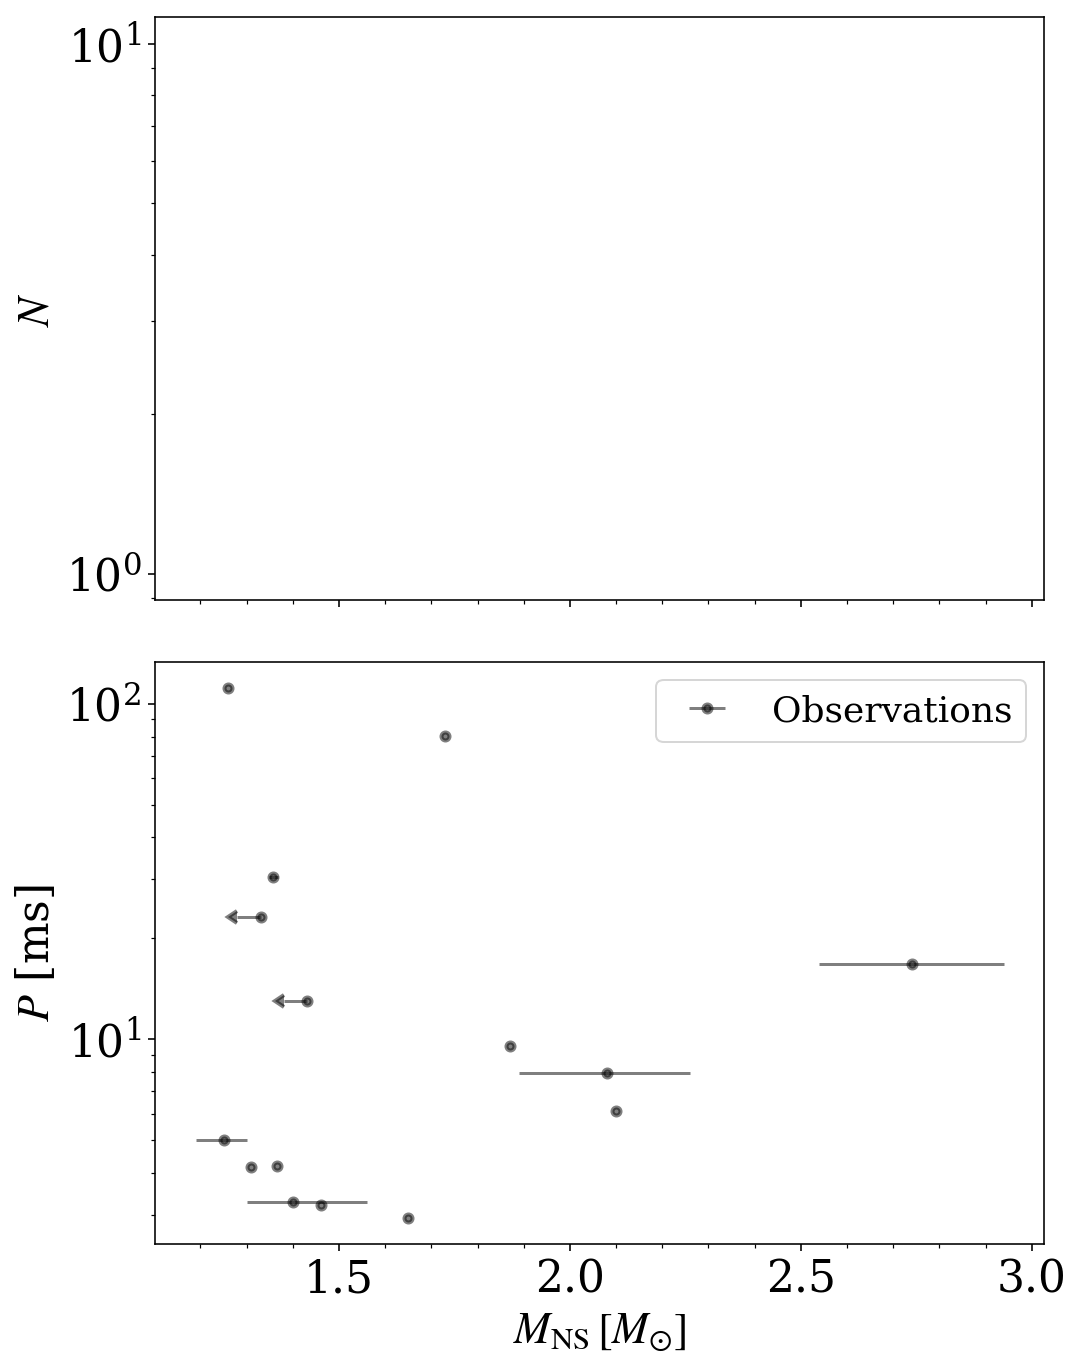

In [27]:
###Number of pulsars and their spin period and magnetic field distribution
###Separating single and binary MSPs
dpsr_mass = pd.read_excel('/projects/b1095/syr904/projects/isolated_MSP/gc_psr_mass.xlsx',
                    names = ['psr_name','mp_med','mp_lsig','mp_usig','mc','mtot', 'pspin'])
mobs = np.array(dpsr_mass['mp_med'])
mobs_lsig = np.array(dpsr_mass['mp_lsig']); mobs_usig = np.array(dpsr_mass['mp_usig'])
print(mobs, mobs[mobs_lsig!=-100], mobs[mobs_lsig==-100])
Ps = np.array(dpsr_mass['pspin'])

N_allpsr = [[],[]]; N_msp = [[],[]]; N_ns = []
N_msp_lmcom = []
Ma_12Gyr = []; Mb_12Gyr = []

id_massive_12 = []; model_massive_12 = []; m_massive_12 = []

id_sin_nontde_nonwdwd = []; n_sin_nontde_nonwdwd = []
id_sin_nontde_nonwdwd_12Gyr = []
t_sin_nontde_nonwdwd_12Gyr = []

fig, axs = plt.subplots(nrows = 2, figsize=(8,10), sharex=True)
for xx in range(len(paths)):
    t_conv = dyn.conv('t', paths[xx]+'initial.conv.sh')
    
    psrfile = paths[xx]+'initial.morepulsars.dat'
    
    mall = []
    Bsin = []; Psin = []; msin = []
    Bbin = []; Pbin = []; mbin = []; mcomp = []; kcomp = []
    thetime = [10000.,13000.]
    timestep_old=14000.
    npsr_sin = []; npsr_bin = []
    nmsp_sin = []; nmsp_bin = []
    nns = []
    nlbh = []
    nlmcomp = []
    
    n_wdwd = [0,0]; n_psrtde_msp = [0,0]; n_nstde_msp = [0,0]
    
    id_massive = []; model_massive = []; m_massive = []
    
    id_sins = []; t_sins = []
    
    id_sin_nontde_nonwdwd.append([]); n_timestep = 0
    
    with open(psrfile, 'r') as fpsr:
        next(fpsr)
        for line in fpsr:
            data = line.split()
            if float(data[1])*t_conv > thetime[1]:
                break
            if float(data[1])*t_conv < thetime[0]:
                continue
            
            timestep = float(data[1])*t_conv
            if timestep>timestep_old:
                n_timestep+=1
                
                if timestep_old<=11000. and timestep>11000.:
                    #if xx<=ab_cut:
                    #    Ma_12Gyr = Ma_12Gyr + mall
                    #else:
                    #    Mb_12Gyr = Mb_12Gyr + mall
                    
                    model_massive_12 = model_massive_12+model_massive
                    id_massive_12 = id_massive_12+id_massive
                    m_massive_12 = m_massive_12+m_massive
                    t_sin_nontde_nonwdwd_12Gyr.append(np.array(t_sins)[np.array(id_sins)!=0])
                    id_sin_nontde_nonwdwd_12Gyr.append(np.array(id_sins)[np.array(id_sins)!=0])
                    
                        
                Psin = np.array(Psin)
                Pbin = np.array(Pbin)
                mall = np.array(mall)
                mcomp = np.array(mcomp); kcomp = np.array(kcomp)
                npsr_sin.append(len(Psin)-n_wdwd[0]+n_nstde_msp[0])
                npsr_bin.append(len(Pbin)-n_wdwd[1]+n_nstde_msp[1])
                nmsp_sin.append(len(Psin[Psin<=0.03])+n_psrtde_msp[0]+n_nstde_msp[0])
                nmsp_bin.append(len(Pbin[Pbin<=0.03])+n_psrtde_msp[1]+n_nstde_msp[1])
                nlmcomp.append(len(mcomp[(mcomp<=0.01) & (kcomp>10)]))
                nns.append(len(mall))
                nlbh.append(len(mall[mall>2.5]))
                
                        
                mall = []
                Bsin = []; Psin = []; msin = []
                Bbin = []; Pbin = []; mbin = []; mcomp = []; kcomp = []
                
                n_wdwd = [0,0]; n_psrtde_msp = [0,0]; n_nstde_msp = [0,0]
                    
                id_massive = []; model_massive = []; m_massive = []
                
                #if xx==6:
                #    print(id_sins, t_sins)
                id_sins = []; t_sins = []
     
                
            if int(data[2])!=1:
                mall.append(float(data[5]))
                if float(data[5])>1.5:
                    model_massive.append(xx); id_massive.append(float(data[3]))
                    m_massive.append(float(data[5]))
                    
                if float(data[7])>=float(data[9])**2*(0.17*10**12):
                    Bsin.append(float(data[7]))
                    Psin.append(float(data[9]))
                    msin.append(float(data[5]))
                    
                    if float(data[9])>0.03 and int(data[3]) in idtde_msp_all[xx]:
                        n_psrtde_msp[0]+=1
                        
                    if float(data[9])>0.03 and (int(data[3]) in id_wdwdcol_all[xx] or 
                                               int(data[3]) in id_wdwdmer_all[xx]):
                        n_wdwd[0]+=1
                        
                    if float(data[9])<=0.03 and (int(data[3]) not in idtde_msp_all[xx] and 
                       int(data[3]) not in id_wdwdcol_all[xx] and int(data[3]) not in id_wdwdmer_all[xx]):
                        id_sin_nontde_nonwdwd[xx].append(int(data[3]))
                        id_sins.append(int(data[3])); t_sins.append(timestep)
                else:
                    if int(data[3]) in idtde_msp_all[xx]:
                        n_nstde_msp[0]+=1
                        
            else:
                if int(data[11])==13:
                    mall.append(float(data[5]))
                    
                    if float(data[5])>1.5:
                        model_massive.append(xx); id_massive.append(float(data[3]))
                        m_massive.append(float(data[5]))
                    
                if int(data[11])==13 and float(data[7])>=float(data[9])**2*(0.17*10**12):
                    Bbin.append(float(data[7]))
                    Pbin.append(float(data[9]))
                    mbin.append(float(data[5]))
                    mcomp.append(float(data[6]))
                    kcomp.append(int(data[12]))
                    
                    
                    if float(data[9])>0.03 and int(data[3]) in idtde_msp_all[xx]:
                        n_psrtde_msp[1]+=1
                        
                    if float(data[9])>0.03 and (int(data[3]) in id_wdwdcol_all[xx] or 
                                               int(data[3]) in id_wdwdmer_all[xx]):
                        n_wdwd[1]+=1
                elif int(data[11])==13 and float(data[7])<float(data[9])**2*(0.17*10**12):
                    if int(data[3]) in idtde_msp_all[xx]:
                        n_nstde_msp[1]+=1
                        mcomp.append(float(data[6]))
                        kcomp.append(int(data[12]))
                
                if int(data[12])==13:
                    mall.append(float(data[6]))
                    
                    if float(data[6])>1.5:
                        model_massive.append(xx); id_massive.append(float(data[4]))
                        m_massive.append(float(data[6]))
                        
                if int(data[12])==13 and float(data[8])>=float(data[10])**2*(0.17*10**12):
                    Bbin.append(float(data[8]))
                    Pbin.append(float(data[10]))
                    mbin.append(float(data[6]))
                    mcomp.append(float(data[5]))
                    kcomp.append(int(data[11]))
                    
                    if float(data[10])>0.03 and int(data[4]) in idtde_msp_all[xx]:
                        n_psrtde_msp[1]+=1
                        
                    if float(data[10])>0.03 and (int(data[4]) in id_wdwdcol_all[xx] or 
                                               int(data[4]) in id_wdwdmer_all[xx]):
                        n_wdwd[1]+=1
                elif int(data[12])==13 and float(data[8])<float(data[10])**2*(0.17*10**12):
                    if int(data[4]) in idtde_msp_all[xx]:
                        n_nstde_msp[1]+=1
                        mcomp.append(float(data[5]))
                        kcomp.append(int(data[11]))
            
            timestep_old = timestep
    
    #print('allpsr:', model_label[xx], np.mean(npsr_sin), np.mean(npsr_bin))
    #print('msp:', model_label[xx], np.mean(nmsp_sin), np.mean(nmsp_bin))
    
    #print('Nns:', model_label[xx], np.mean(nns))
    #print('low-mass bh?', model_label[xx], np.mean(nlbh))
    #print('low-mass companion', model_label[xx], np.mean(nlmcomp))
        
    N_allpsr[0].append(np.mean(npsr_sin)); N_allpsr[1].append(np.mean(npsr_bin))
    N_msp[0].append(np.mean(nmsp_sin)); N_msp[1].append(np.mean(nmsp_bin))
    N_ns.append(np.mean(nns))
    N_msp_lmcom.append(np.mean(nlmcomp))
    
    n_sin_nontde_nonwdwd.append(len(np.array(id_sin_nontde_nonwdwd[xx])[np.array(id_sin_nontde_nonwdwd[xx])!=0])/
                                float(n_timestep+1))
    id_sin_nontde_nonwdwd[xx] = list(Counter(id_sin_nontde_nonwdwd[xx]).keys())
    
print('sin MSP ids', id_sin_nontde_nonwdwd)
#print('sin MSP 13 Gyr ids', id_sin_nontde_nonwdwd_13Gyr, t_sin_nontde_nonwdwd_13Gyr)
#np.savetxt('/projects/b1095/syr904/projects/isolated_MSP/massive_NS.dat', 
#           np.c_[model_massive_12,id_massive_12,m_massive_12],
#          fmt = '%d %d %f', header = '1.model 2.id 3.NS_mass[MSUN]', comments = '#', delimiter = '')

#print(len(Ma_12Gyr), len(np.array(Ma_12Gyr)[np.array(Ma_12Gyr)>1.5])) 
#print(len(Mb_12Gyr), len(np.array(Mb_12Gyr)[np.array(Mb_12Gyr)>1.5]))    
#axs[0].hist(Ma_12Gyr, bins=15,
#         histtype='step', alpha=0.6, color = 'b', lw=3)
#axs[0].hist(Mb_12Gyr, bins=15,
#         histtype='step', alpha=0.6, color = 'orange', lw=3)
axs[1].errorbar(mobs[mobs_lsig!=-100], 
             Ps[mobs_lsig!=-100], 
             xerr = [mobs_lsig[mobs_lsig!=-100], mobs_usig[mobs_lsig!=-100]], 
             marker='o', markersize=4, linestyle='none',markeredgewidth=2,
             capsize=0, color = 'k', alpha=0.5, label = 'Observations')
axs[1].errorbar(mobs[mobs_lsig==-100], 
             Ps[mobs_lsig==-100], 
             xuplims = True, xerr=0.05,
             marker='o', markersize=4, linestyle='none',markeredgewidth=2,
             color = 'k', alpha=0.5)


axs[0].xaxis.set_minor_locator(AutoMinorLocator())
axs[0].set_ylabel(r'$N$')
axs[0].set_yscale('log')
axs[1].set_ylabel(r'$P$ [ms]')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$M_{\rm{NS}}\,[M_{\odot}]$')
axs[1].legend(loc='upper right', fontsize=18)
fig.tight_layout()

#plt.savefig(savepath+'ns_mass_all_12Gyr.pdf', dpi=300)

data_sin_msp = [n_sin_nontde_nonwdwd, N_msp_lmcom, list(np.array(N_msp_lmcom)+np.array(n_sin_nontde_nonwdwd))]
pd.DataFrame(data_sin_msp)
#print('number of single MSPs', N_msp_lmcom, n_sin_nontde_nonwdwd, np.array(N_msp_lmcom)+np.array(n_sin_nontde_nonwdwd))

In [28]:
###### Save the arrays into a file
np.savetxt(savepath+'table_1851.dat', np.c_[Mclu, N_bh, N_ns, N_wdwdcoll_tot, N_wdwdmer_tot, N_tde, 
                                       np.array(N_allpsr[0])+np.array(N_allpsr[1]), 
                                       N_BBH, N_DNS, N_NSBH, N_BHWD, N_NSWD, N_DWD,
                                       N_NSWD_pres, N_DNS_pres, N_NSBH_pres,
                                       N_ns2bh, N_dns2bh, N_nswd2bh],
          fmt = '%f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f',
          header = '1.Mclu 2.Nbh 3.Nns 4.Nwdcolltot 5.Nwdmertot 6.Ntde 7.Nallpsr 8.NBBH 9.NBNS 10.NBHNS 11.NBHWD 12.NNSWD 13.NDWD 14.NNSWD_pres 15.NDNS_pres 16.NNSBH_pres 17.Nns2bh 18.Ndns2bh 19.Nnswd2bh',
          delimiter = ' ')
#data_table = np.genfromtxt(savepath+'table.dat')
#np.savetxt(savepath+'table.dat', np.c_[data_table[:,0],data_table[:,1],data_table[:,2],data_table[:,3],
#              data_table[:,4],data_table[:,5],data_table[:,6],data_table[:,7],data_table[:,8],
#              data_table[:,9],data_table[:,10],N_ns_wdwdmer[0],N_ns_wdwdmer[1]],
#          fmt = '%f %f %f %f %f %f %f %f %f %f %f %f %f',
#          header = '1.Mclu 2.Nbh 3.Nns 4.Nwdcolltot 5.Ntde 6.Nallpsr_sin 7.Nallpsr_bin 8.Nmsp_sin 9.Nmsp_bin 10.Nnscoll_sin 11.Nnscoll_bin 12.Nnsmer_sin 13.Nnsmer_bin',
#          delimiter = ' ')

data_table = np.genfromtxt(savepath+'table_1851.dat')
f=open(savepath+'latex_table_1851.txt', 'w+')
name_label = ['', '^{dm}']
for ii in range(len(paths)):
    f.write('%s & %.2f & %d & %d & %d & %d & %d & %d & %d & %d & %s & %s & %s & %s & %s\\\\\n'
            %(str(ii+1)+name_label[ii], 
              data_table[:,0][ii]/1.e5, np.round(data_table[:,1][ii]),
              np.round(data_table[:,2][ii]),
              np.round(data_table[:,16][ii]),np.round(data_table[:,17][ii]),np.round(data_table[:,18][ii]),
              np.round(data_table[:,13][ii]),np.round(data_table[:,14][ii]),np.round(data_table[:,15][ii]),
              snmodel[ii], wdmassmodel[ii], nstdeflag[ii], wdtcflag[ii], qcritflag[ii]))

f.close()